# Load Base Packages

In [27]:
import pandas as pd
import sys
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import loguniform


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [28]:
# check ohe data
test = pd.read_csv("../01_clean_data/adult_ohe.csv")
test.head()

,income,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,39,77516,13,2174,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0,50,83311,13,0,0,13,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,38,215646,9,0,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,53,234721,7,0,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,28,338409,13,0,0,40,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Preprocess Data (Needed)

In [29]:
data = pd.read_csv("../00_original_data/adult.csv")
data = data.replace("?", None)
data["income"] = data["income"].replace(
    {"<=50K.": 0, "<=50K": 0, ">50K": 1, ">50K.": 1}
)
data.insert(0, "income", data.pop("income"))
data["native-country_United-States"] = (
    data["native-country"] == "United-States"
).astype(int)
data.drop("native-country", axis=1, inplace=True)

# grab numeric cols
numeric_cols = [
    "age",
    "fnlwgt",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]
# grab categroical cols
categorical_cols = [
    "native-country_United-States",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]

feature_names = data.columns.tolist()[1:]
print(feature_names)

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_cols]
numerical_columns_indices = [
    feature_names.index(fn) for fn in feature_names if fn not in categorical_cols
]

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country_United-States']


In [30]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoded_data = encoder.fit_transform(data[categorical_cols])

# Create DataFrame for encoded features with proper column naming
new_column_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=new_column_names)

In [4]:
encoded_df

,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
48838,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
48839,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
48840,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [31]:
# Drop the original categorical columns and join the encoded data
data = data.drop(categorical_cols, axis=1)
data = pd.concat([data, encoded_df], axis=1)

In [32]:
feature_names = data.columns.tolist()[1:]
data.head()

,income,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,39,77516,13,2174,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0,50,83311,13,0,0,13,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,38,215646,9,0,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,53,234721,7,0,0,40,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,28,338409,13,0,0,40,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [33]:
# extract data
X_ohe = data[feature_names]
y = data["income"]

X_full, X_test, y_full, y_test = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42
)

In [34]:
X_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
10158,20,320047,6,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9517,27,200492,13,0,0,40,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
26495,39,336880,9,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45350,23,189194,10,0,0,40,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11996,90,40388,13,0,0,55,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [35]:
scaler = StandardScaler()
X_ohe[numeric_cols] = scaler.fit_transform(X_ohe[numeric_cols])
# should be same sampling as original
X_full_ss, X_test_ss, y_full_ss, y_test_ss = train_test_split(
    X_ohe, y, test_size=0.2, random_state=42
)
# should be same sampling as original
X_train_ss, X_val_ss, y_train_ss, y_val_ss = train_test_split(
    X_full_ss, y_full_ss, test_size=0.20, random_state=42
)

In [36]:
X_train_ss.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
10158,-1.359816,1.234652,-1.586221,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9517,-0.849254,0.102534,1.136512,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
26495,0.025996,1.394051,-0.419335,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45350,-1.141004,-0.004452,-0.030373,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11996,3.745808,-1.413560,1.136512,-0.144804,-0.217127,1.176438,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [37]:
X_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
10158,20,320047,6,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9517,27,200492,13,0,0,40,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
26495,39,336880,9,0,0,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45350,23,189194,10,0,0,40,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11996,90,40388,13,0,0,55,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Load and Split Dataset

In [186]:
# adult_ohe = pd.read_csv("../01_clean_data/adult_ohe.csv")

# X = adult_ohe.drop(columns=["income"])
# y = adult_ohe["income"]

# # need to do preprorcessing here and check if this will work proprely


# # make sure to have train, val, and test
# # I orginally messed up here where I only did a train and val split, so the model needs to be retrained on random
# # I move on to make sure we have global-agonstic methods established
# X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_full, y_full, test_size=0.20, random_state=42
# )

# Build MLP Classifer 

In [38]:
from sklearn.neural_network import MLPClassifier

# defualt params for MLP classifier
default_params = {
    "hidden_layer_sizes": (30, 30),
    "learning_rate_init": 0.03,
    "alpha": 0,
    "solver": "sgd",
    "tol": 1e-5,
    "early_stopping": False,
    "activation": "relu",
    "n_iter_no_change": 1000,
    "batch_size": 50,
    "max_iter": 500,
    "random_state": 42,
    "warm_start": True,
}

mlp = MLPClassifier(**default_params)
mlp.fit(X_train_ss, y_train_ss)
print("MLP Classifier model has fitted")

MLP Classifier model has fitted


In [39]:
# calc scores on validation data
y_pred_proba = mlp.predict_proba(X_val_ss)[:, 1]
auc_default = roc_auc_score(y_val_ss, y_pred_proba)
ap_defualt = average_precision_score(y_val_ss, y_pred_proba)
print("ROC_AUC score:", auc_default)
print("AP score:", ap_defualt)

ROC_AUC score: 0.8794963484048759
AP score: 0.725662444831982


In [291]:
X_train.dtypes

age                int64
fnlwgt             int64
education-num      int64
capital-gain       int64
capital-loss       int64
                  ...   
race_Black       float64
race_Other       float64
race_White       float64
sex_Female       float64
sex_Male         float64
Length: 70, dtype: object

In [295]:
# remove later this is just tesitng the pdp data transformer
from pdpbox import pdp, info_plots

X_train_copy = X_train.copy()


# use this to transfrom origianl scaled data
def data_trans(df, scaler=scaler):
    print(df["age"].unique())
    numeric_cols = [
        "age",
        "fnlwgt",
        "education-num",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
    ]
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    print("*" * 50)
    print(df["age"].unique())
    return df


pdp_age = pdp.PDPIsolate(
    model=mlp,
    df=X_train_copy,
    model_features=X_train_ss.columns,
    feature="age",
    feature_name="Age",
    data_transformer=data_trans,
    n_classes=2,
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

[17.]
**************************************************
[-1.57862888]
[22.]
**************************************************
[-1.21394141]
[26.]
**************************************************
[-0.92219144]
[31.]
**************************************************
[-0.55750397]
[35.]
**************************************************
[-0.26575399]
[39.]
**************************************************
[0.02599598]
[44.]
**************************************************
[0.39068346]
[49.]
**************************************************
[0.75537093]
[57.]
**************************************************
[1.33887088]
[90.]
**************************************************
[3.74580818]


In [296]:
fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    plot_pts_dist=False,
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

In [285]:
# make sure plots are similar
X_train_copy = X_train.copy()

pdp_age_ss = pdp.PDPIsolate(
    model=mlp,
    df=X_train_copy,
    model_features=X_train_copy.columns,
    feature="age",
    feature_name="Age",
    n_classes=2,
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [286]:
fig, axes = pdp_age_ss.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    plot_pts_dist=False,
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

[20 27 39 23 90 38 47 48 59 21 53 30 22 45 40 31 67 24 25 56 51 37 34 28
 41 26 49 35 43 33 50 36 32 57 44 61 54 55 58 63 46 42 65 18 70 52 29 62
 17 66 19 75 77 64 69 68 71 60 78 79 81 83 76 74 84 73 80 72 87 82 85 88
 89 86]
**************************************************
[-1.3598164  -0.84925394  0.02599598 -1.14100392  3.74580818 -0.04694151
  0.60949594  0.68243343  1.48474587 -1.28687891  1.0471209  -0.63044146
 -1.21394141  0.46362095  0.09893348 -0.55750397  2.06824582 -1.06806643
 -0.99512893  1.26593338  0.90124591 -0.119879   -0.33869149 -0.77631645
  0.17187097 -0.92219144  0.75537093 -0.26575399  0.31774596 -0.41162898
  0.82830842 -0.1928165  -0.48456647  1.33887088  0.39068346  1.63062085
  1.1200584   1.19299589  1.41180837  1.77649584  0.53655844  0.24480847
  1.92237083 -1.50569139  2.2870583   0.97418341 -0.70337896  1.70355835
 -1.57862888  1.99530833 -1.4327539   2.65174577  2.79762076  1.84943334
  2.21412081  2.14118331  2.3599958   1.55768336  2.87055825  2.9

array([[<Axes: xlabel='age', ylabel='ALE'>,
        <Axes: xlabel='fnlwgt', ylabel='ALE'>,
        <Axes: xlabel='education-num', ylabel='ALE'>],
       [<Axes: xlabel='capital-gain', ylabel='ALE'>,
        <Axes: xlabel='capital-loss', ylabel='ALE'>,
        <Axes: xlabel='hours-per-week', ylabel='ALE'>]], dtype=object)

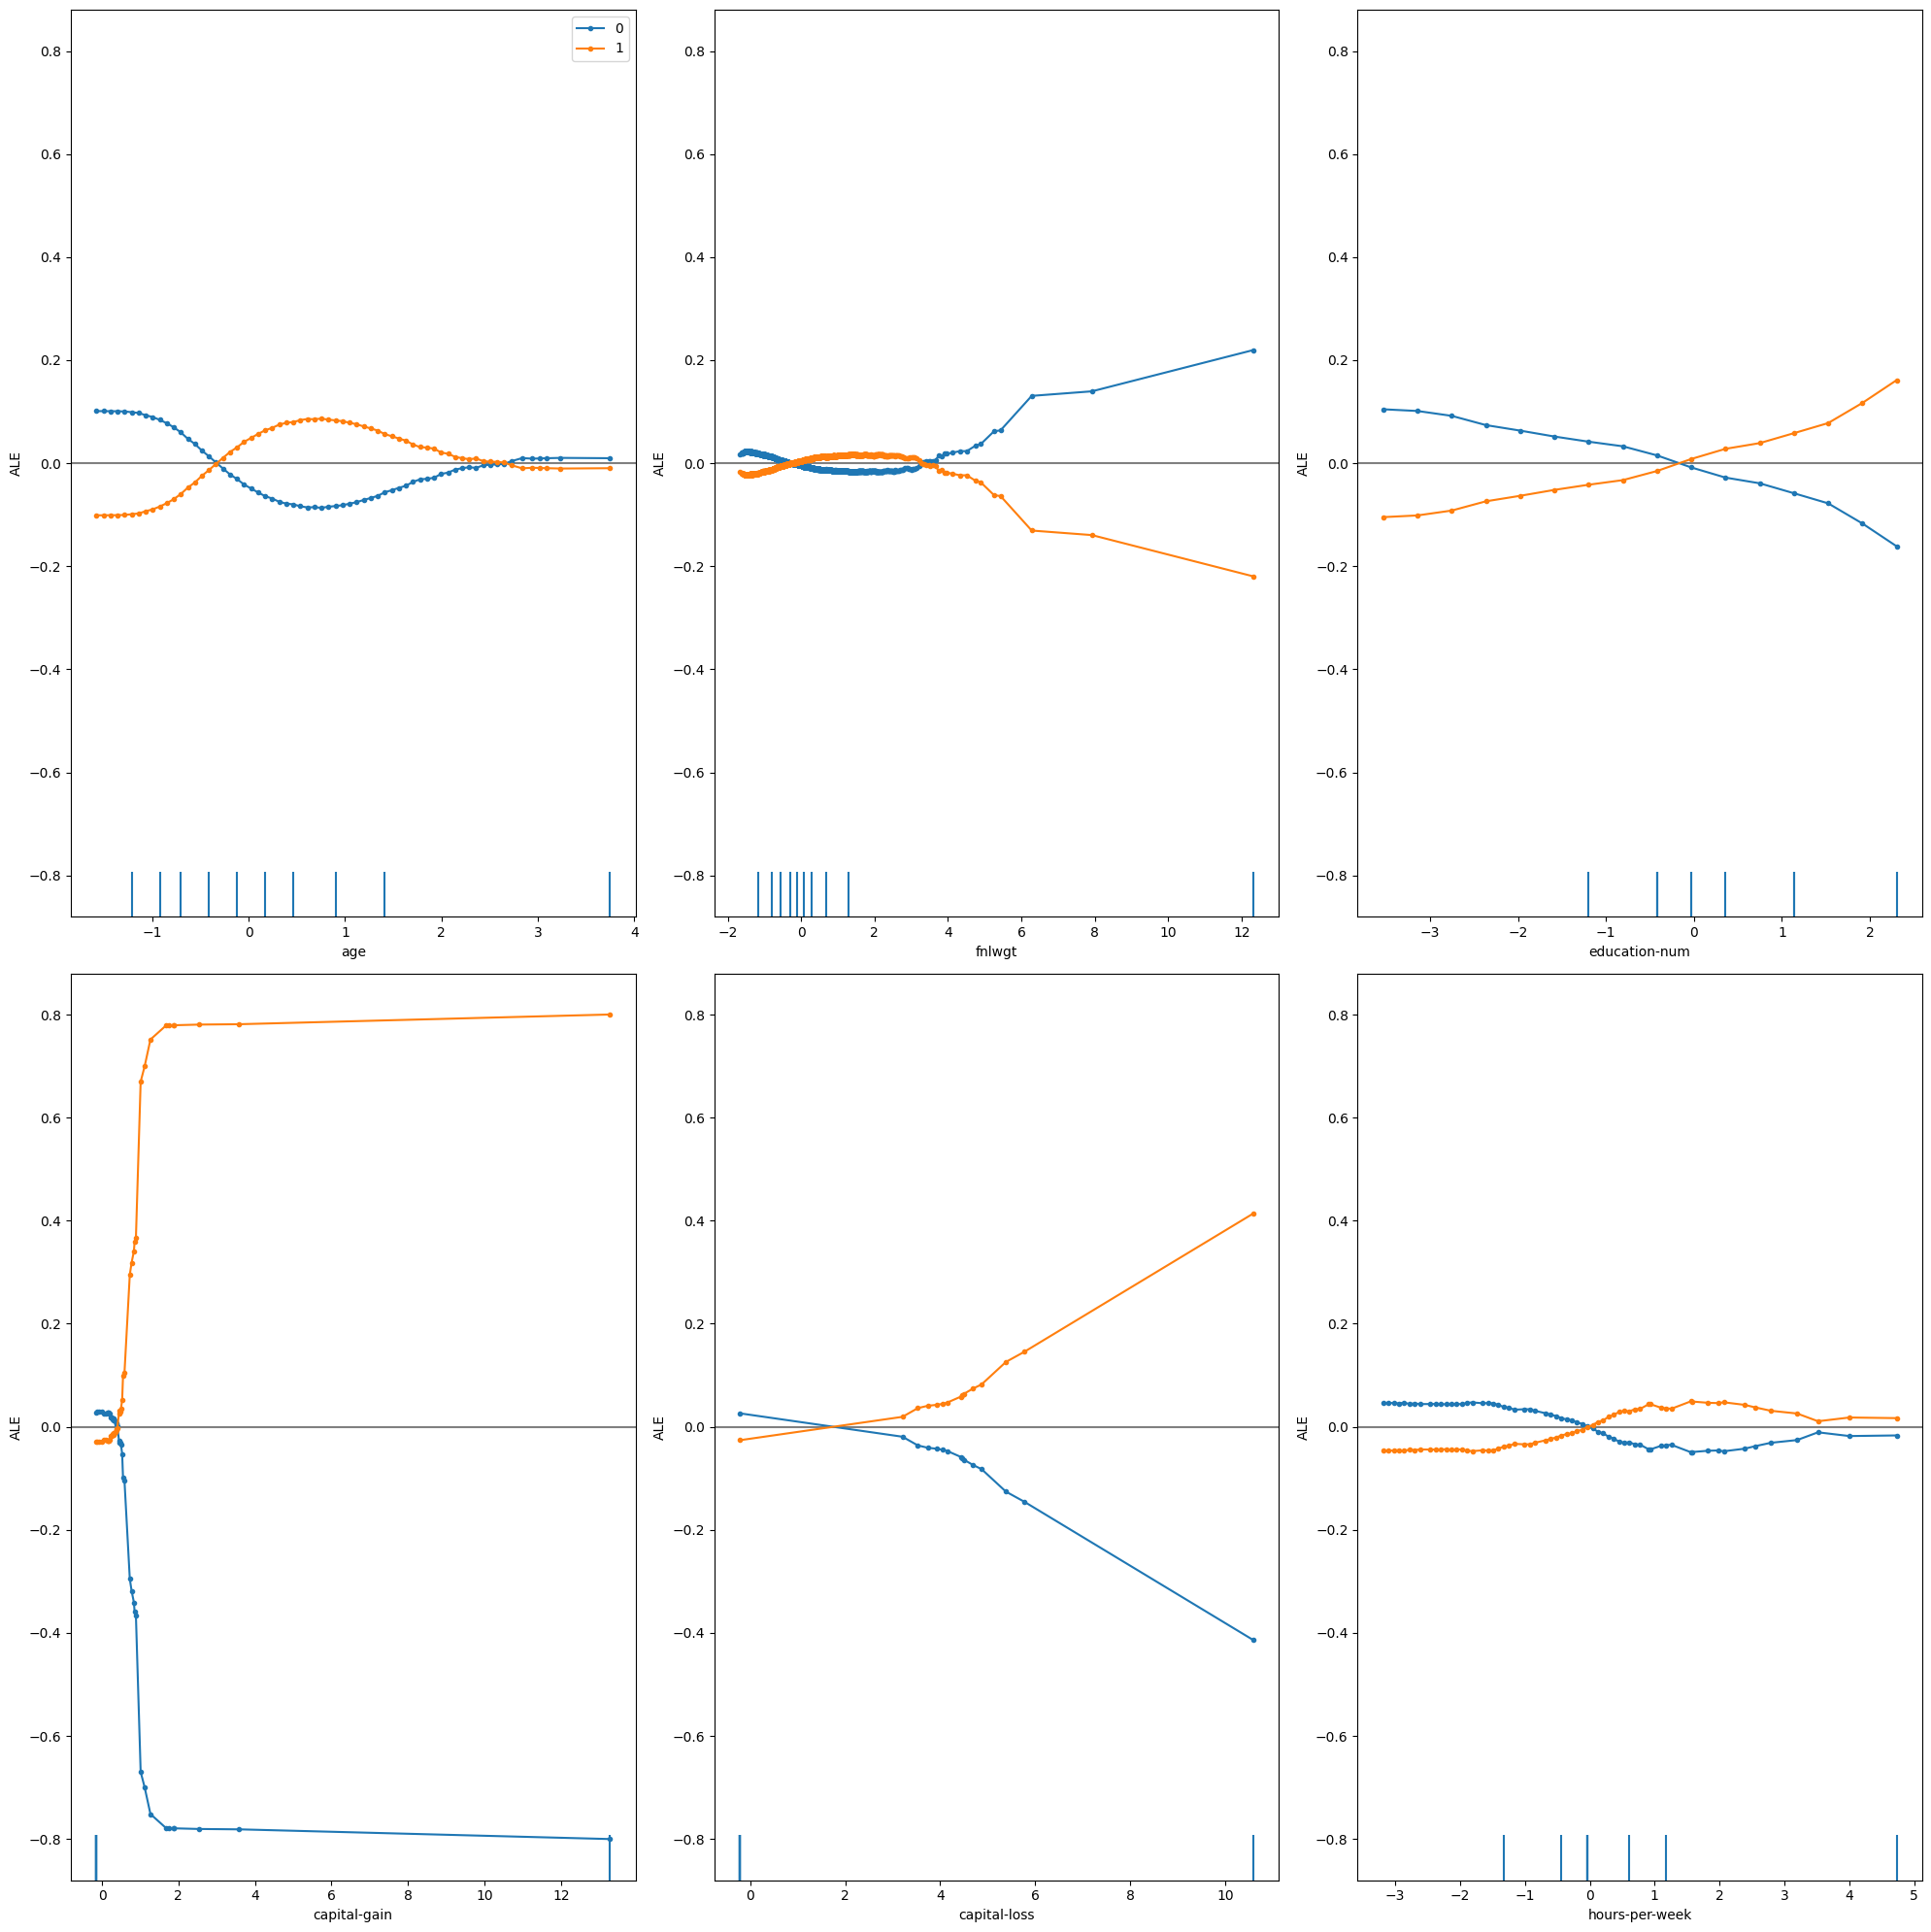

In [297]:
# do Accumulated Local Effects plots
# first test if it will work for scaled data
from alibi.explainers import ALE, plot_ale

# categorical features aren't good for this
# ALE formulation and hence any results for categorical variables would be misleading.
target_names = y_train_ss.unique().tolist()
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(
    proba_fun_lr, feature_names=X_train_ss.columns.tolist(), target_names=target_names
)
proba_exp_lr = proba_ale_lr.explain(data_trans(X_train).values)
# how are you supposed to interpret this
plot_ale(
    proba_exp_lr,
    n_cols=3,
    features=[0, 1, 2, 3, 4, 5],
    fig_kw={"figwidth": 20, "figheight": 20},
)

In [298]:
X_val_ss

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country_United-States_0,native-country_United-States_1,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
19994,-0.411629,-0.433824,1.136512,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
26088,-1.578629,0.339412,-1.197259,-0.144804,-0.217127,-2.051629,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1701,-1.505691,-1.358079,-0.030373,-0.144804,-0.217127,-2.051629,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
16709,-0.192816,-0.800415,-0.419335,-0.144804,-0.217127,0.772930,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
51,-1.505691,0.353133,-0.419335,-0.144804,-0.217127,-0.841104,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853,-1.505691,-0.202420,-0.419335,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
34543,2.141183,-0.745558,-0.419335,-0.144804,-0.217127,-0.679700,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
10156,-0.776316,1.636572,-0.419335,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11862,-1.141004,-0.166824,-0.419335,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [12]:
# just do shap
import shap


def f(x):
    return mlp.predict_proba(x)[:, 1]


# baseline for comparion
med = X_train_ss.median().values.reshape((1, X_train_ss.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_val_ss)

PermutationExplainer explainer: 7816it [00:18, 201.62it/s]                          


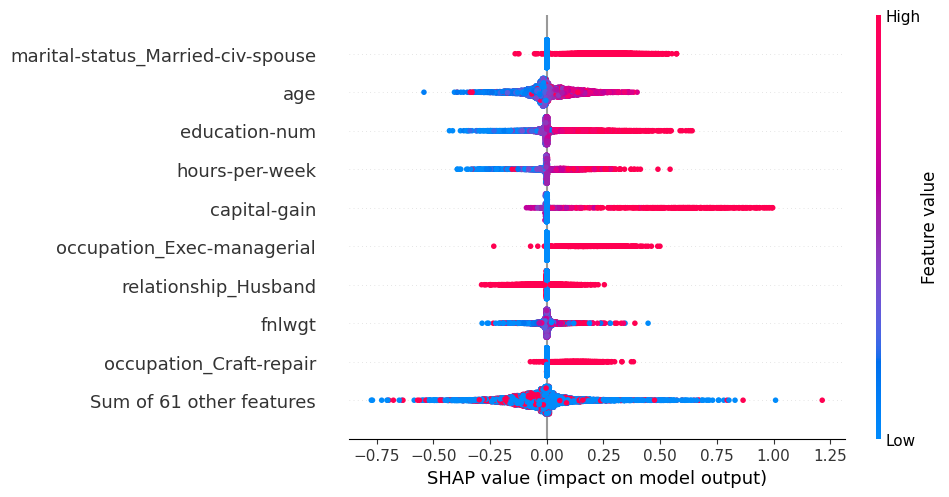

In [13]:
# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
shap.plots.beeswarm(shap_values)

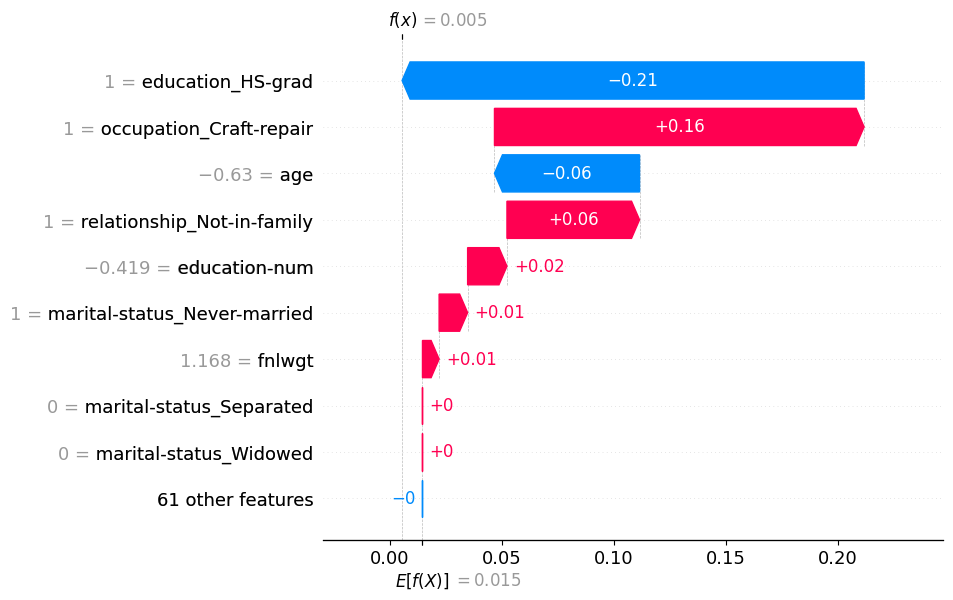

In [18]:
shap.plots.waterfall(shap_values[11])

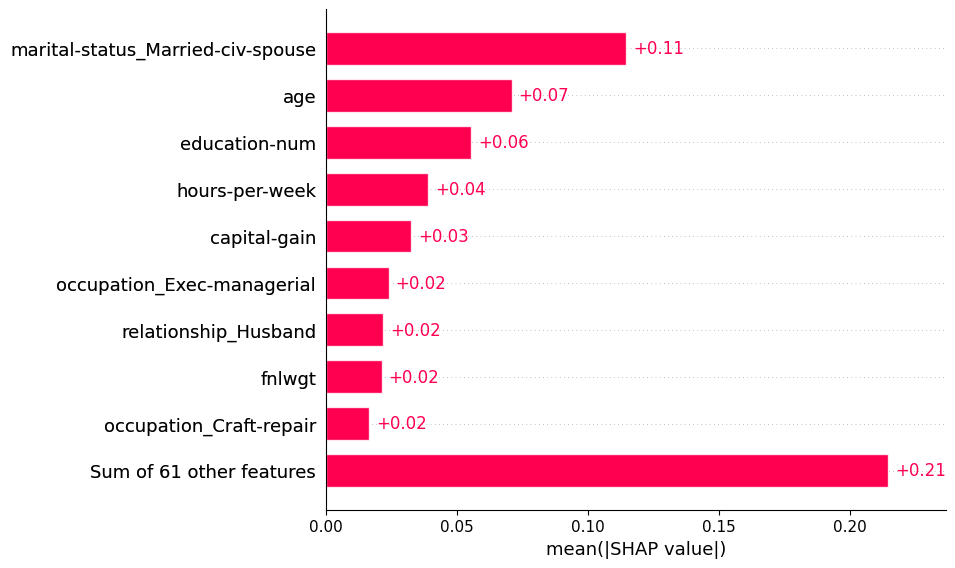

In [15]:
shap.plots.bar(shap_values)

In [43]:
# implement random search to find good params
# default params for random search mlp model
nodes = [1, 2, 3, 4, 5, 10, 15, 25, 30]
layers = [1, 2, 3, 4]

random_params = {
    "solver": "sgd",
    "tol": 1e-5,
    "early_stopping": False,
    "activation": "relu",
    "n_iter_no_change": 1000,
    "random_state": 42,
    "warm_start": True,
}

# random search hyperparameters to look over, just use same hyperparameters I looked over above
random_hyperparameters = {
    "hidden_layer_sizes": [(n,) * l for n in nodes for l in layers],
    "learning_rate_init": loguniform(1e-5, 1e-0),
    "alpha": loguniform(1e-8, 1e-2),
    "batch_size": [1, 3, 5, 10, 20, 50, 100, 250, 500],
    "max_iter": [500, 750, 1000, 1500],
}

mlp_r = MLPClassifier(**random_params)
random_search = RandomizedSearchCV(
    mlp_r,
    param_distributions=random_hyperparameters,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
)
random_search.fit(X_train_ss, y_train_ss)
print("(e) MLP random search model has been fitted")

(e) MLP random search model has been fitted


In [44]:
merged_params = {**random_search.best_params_, **random_params}
print("The best params for the MLP Classifier are: ")
merged_params

The best params for the MLP Classifier are: 


{'alpha': 3.39590093316275e-08,
 'batch_size': 100,
 'hidden_layer_sizes': (10,),
 'learning_rate_init': 0.000877781550471965,
 'max_iter': 750,
 'solver': 'sgd',
 'tol': 1e-05,
 'early_stopping': False,
 'activation': 'relu',
 'n_iter_no_change': 1000,
 'random_state': 42,
 'warm_start': True}

In [46]:
best_random_mlp = random_search.best_estimator_
# calc scores on validation data
y_pred_proba = best_random_mlp.predict_proba(X_val_ss)[:, 1]
auc_random = roc_auc_score(y_val_ss, y_pred_proba)
ap_random = average_precision_score(y_val_ss, y_pred_proba)
print("ROC_AUC score:", auc_random)
print("AP score:", ap_random)

ROC_AUC score: 0.9109787771668553
AP score: 0.7790057627687389


# Refit with train+val data and see how it performs on test data

In [47]:
mlp_final = MLPClassifier(**merged_params)
mlp_final.fit(X_full_ss, y_full_ss)

MLPClassifier(alpha=3.39590093316275e-08, batch_size=100,
              hidden_layer_sizes=(10,), learning_rate_init=0.000877781550471965,
              max_iter=750, n_iter_no_change=1000, random_state=42,
              solver='sgd', tol=1e-05, warm_start=True)

In [48]:
y_pred_proba = mlp_final.predict_proba(X_test_ss)[:, 1]
auc_final = roc_auc_score(y_test_ss, y_pred_proba)
ap_final = average_precision_score(y_test_ss, y_pred_proba)
print("ROC_AUC score:", auc_final)
print("AP score:", ap_final)
y_pred = mlp_final.predict(X_test_ss)

accuracy_final = accuracy_score(y_test_ss, y_pred)
precision_final = precision_score(y_test_ss, y_pred)
recall_final = recall_score(y_test_ss, y_pred)
f1_final = f1_score(y_test_ss, y_pred)

print("Accuracy:", accuracy_final)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

ROC_AUC score: 0.9113480149164059
AP score: 0.7804724814924595
Accuracy: 0.8561777049851571
Precision: 0.7411167512690355
Recall: 0.6199575371549894
F1 Score: 0.6751445086705202


# Global-Agonistic Methods

### SHAP Feature Importance

In [99]:
import shap


def f(x):
    return mlp.predict_proba(x)[:, 1]


# baseline for comparion
med = X_train_ss.median().values.reshape((1, X_full_ss.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test_ss)

PermutationExplainer explainer: 9770it [00:22, 240.72it/s]                          


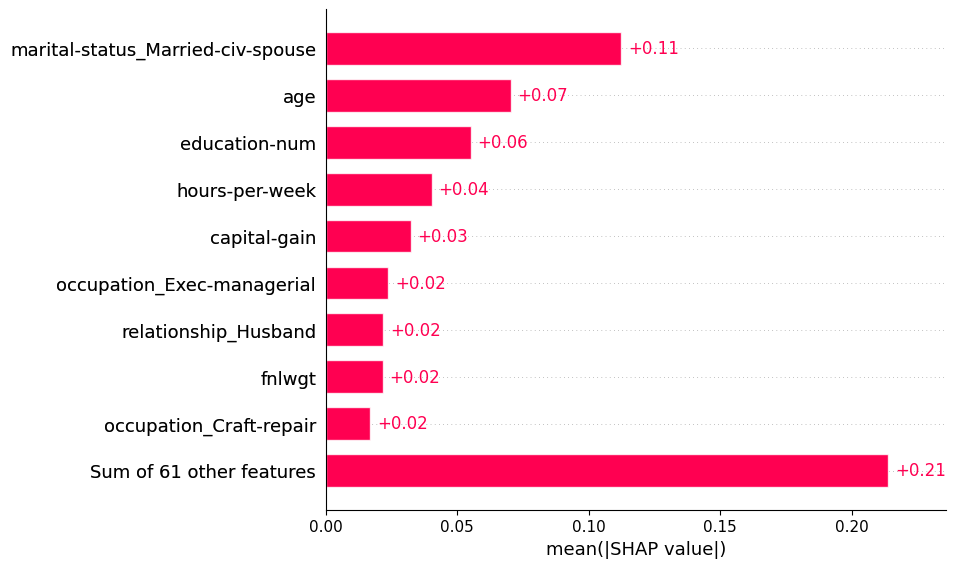

In [103]:
shap.plots.bar(shap_values)

### Partial Dependecy Plots

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

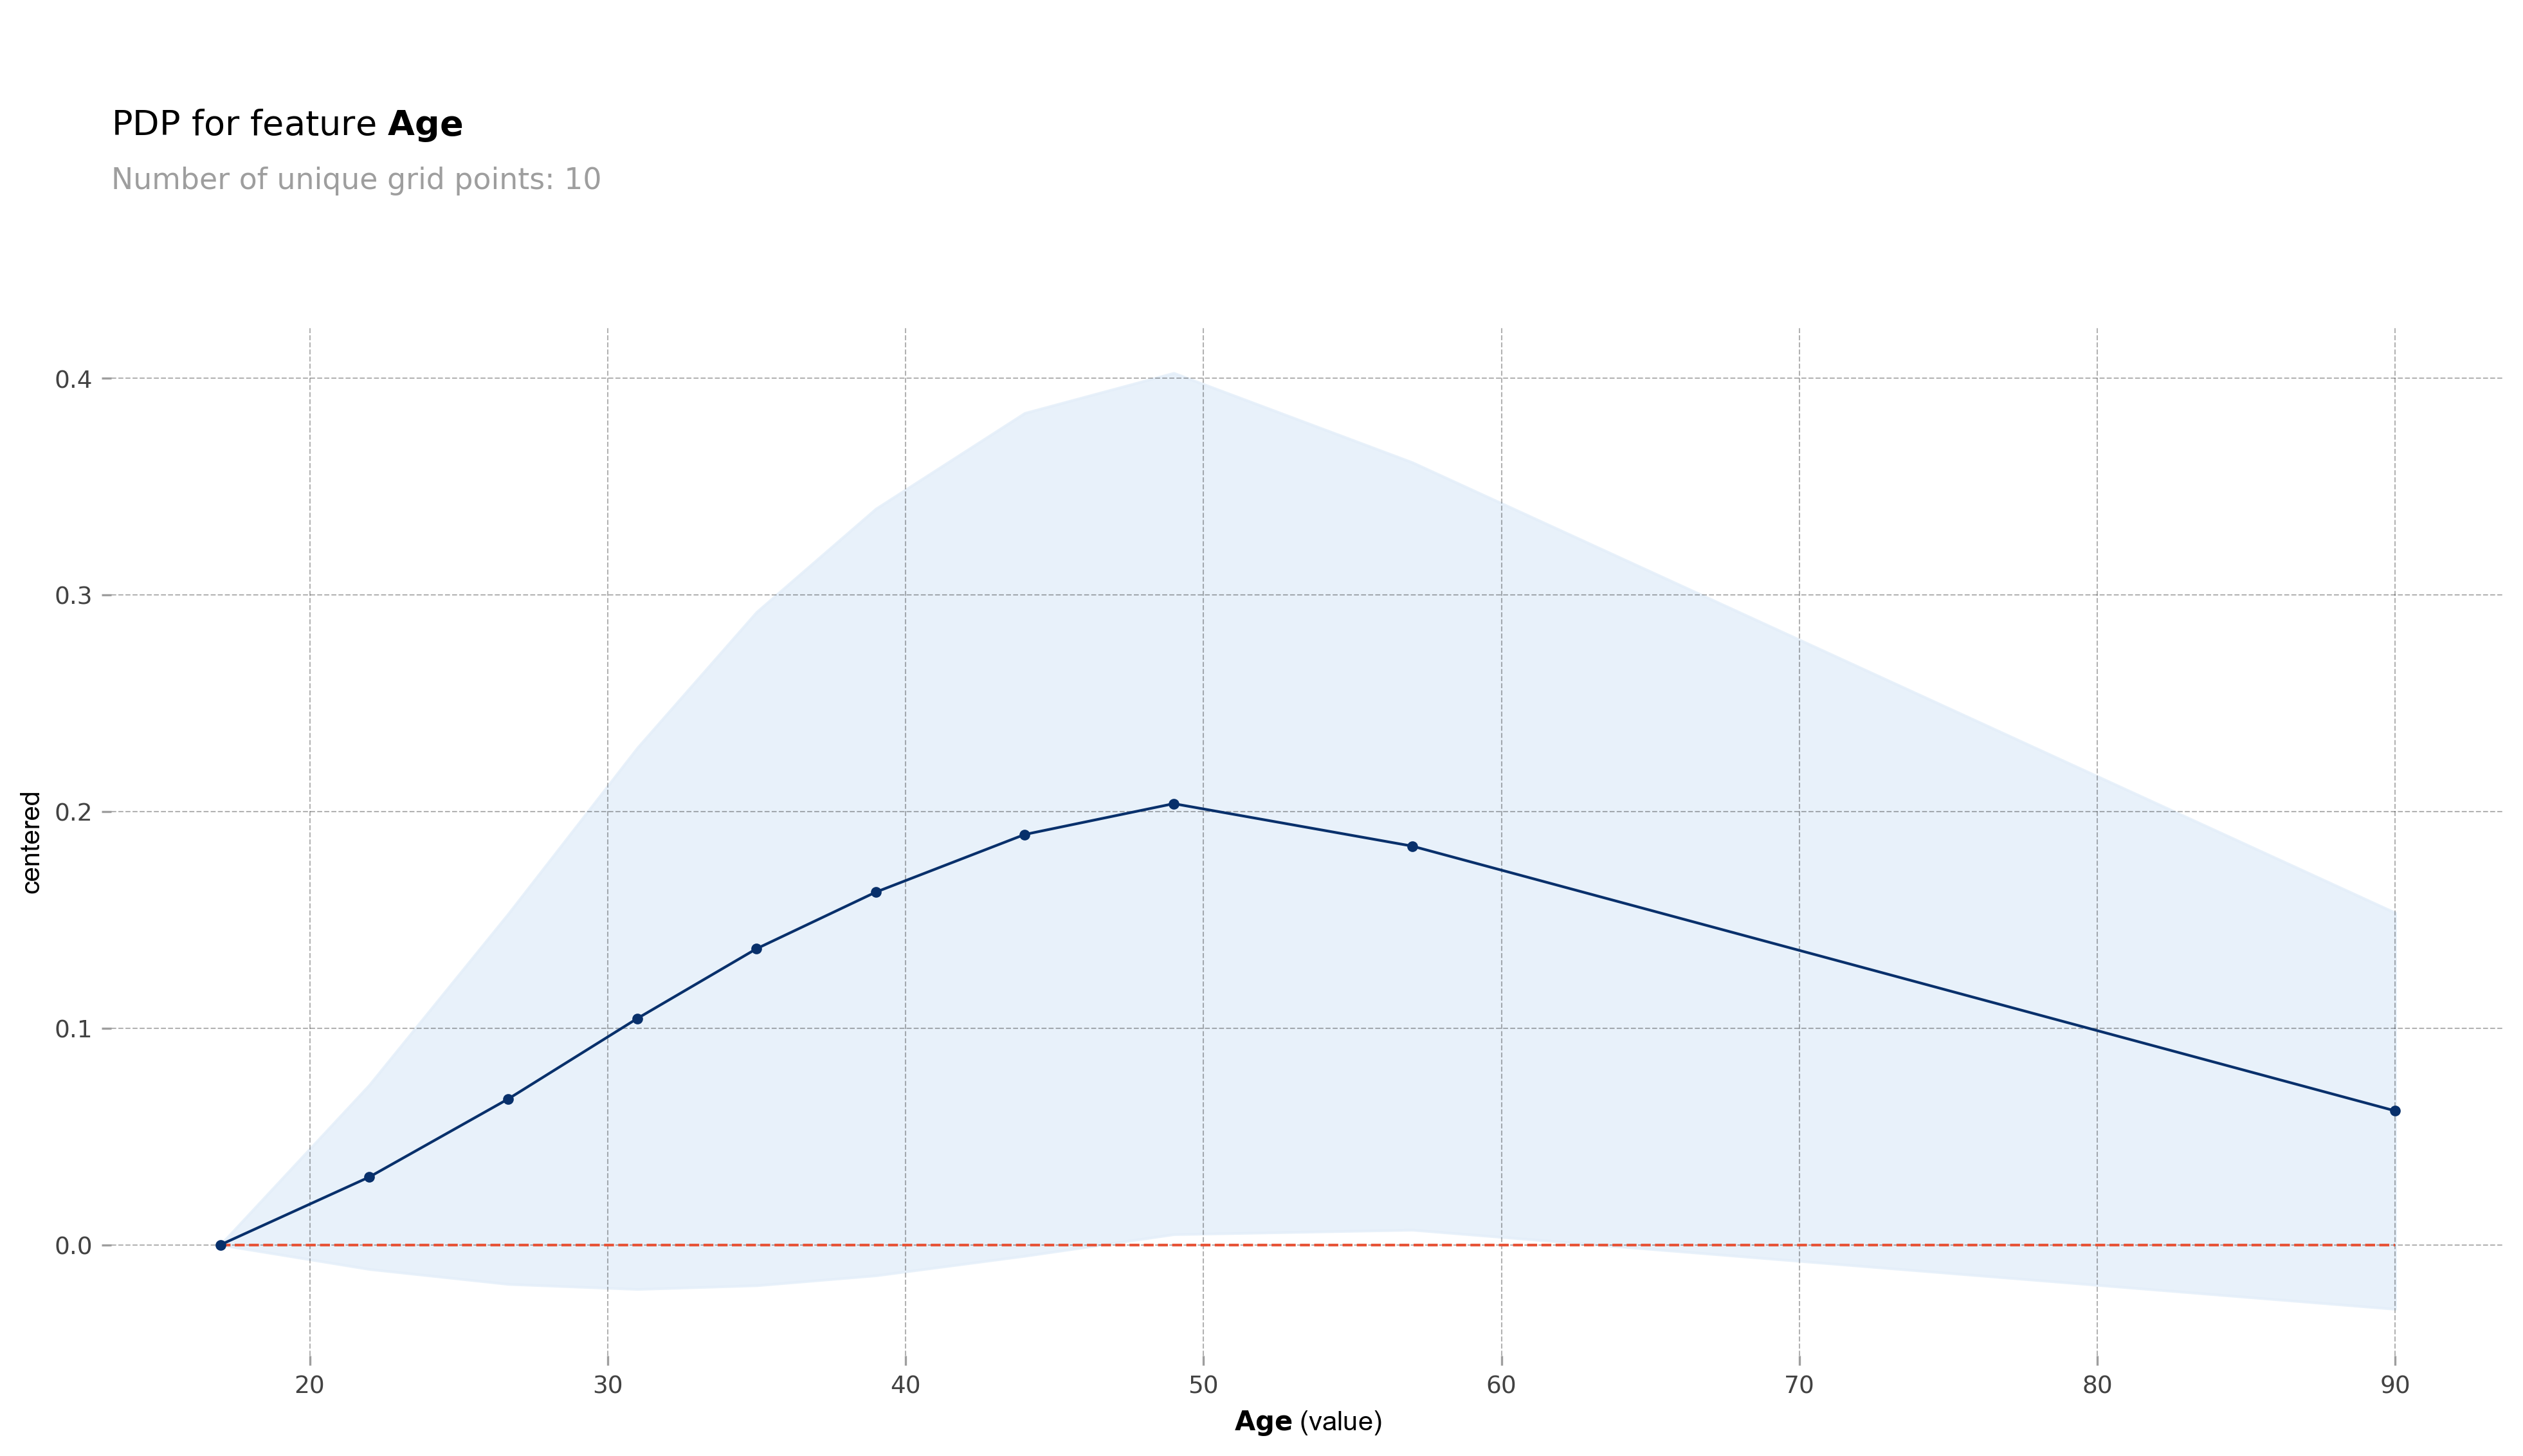

In [108]:
# pip install pdpbox
from pdpbox import pdp, info_plots
from sklearn.preprocessing import StandardScaler

# going though examples for team so it won't be complete, but will finish later
X_full_copy = X_full.copy()


# use this to transfrom origianl scaled data
def data_trans(df, scaler=scaler):
    numeric_cols = [
        "age",
        "fnlwgt",
        "education-num",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
    ]
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    return df


# numerical feature
pdp_age = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="age",
    feature_name="Age",
    data_transformer=data_trans,
    n_classes=2,
)

# "age" is scaled so this will cause issues, will talk to Babara about this
# scaling the data isn't feasible
# when you scale your data, the original meaning of the features may become less directly interpretable

fig, axes = pdp_age.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.show()

In [66]:
# group them together
marrige_columns = [col for col in X_full.columns if col.startswith("marital-status_")]

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

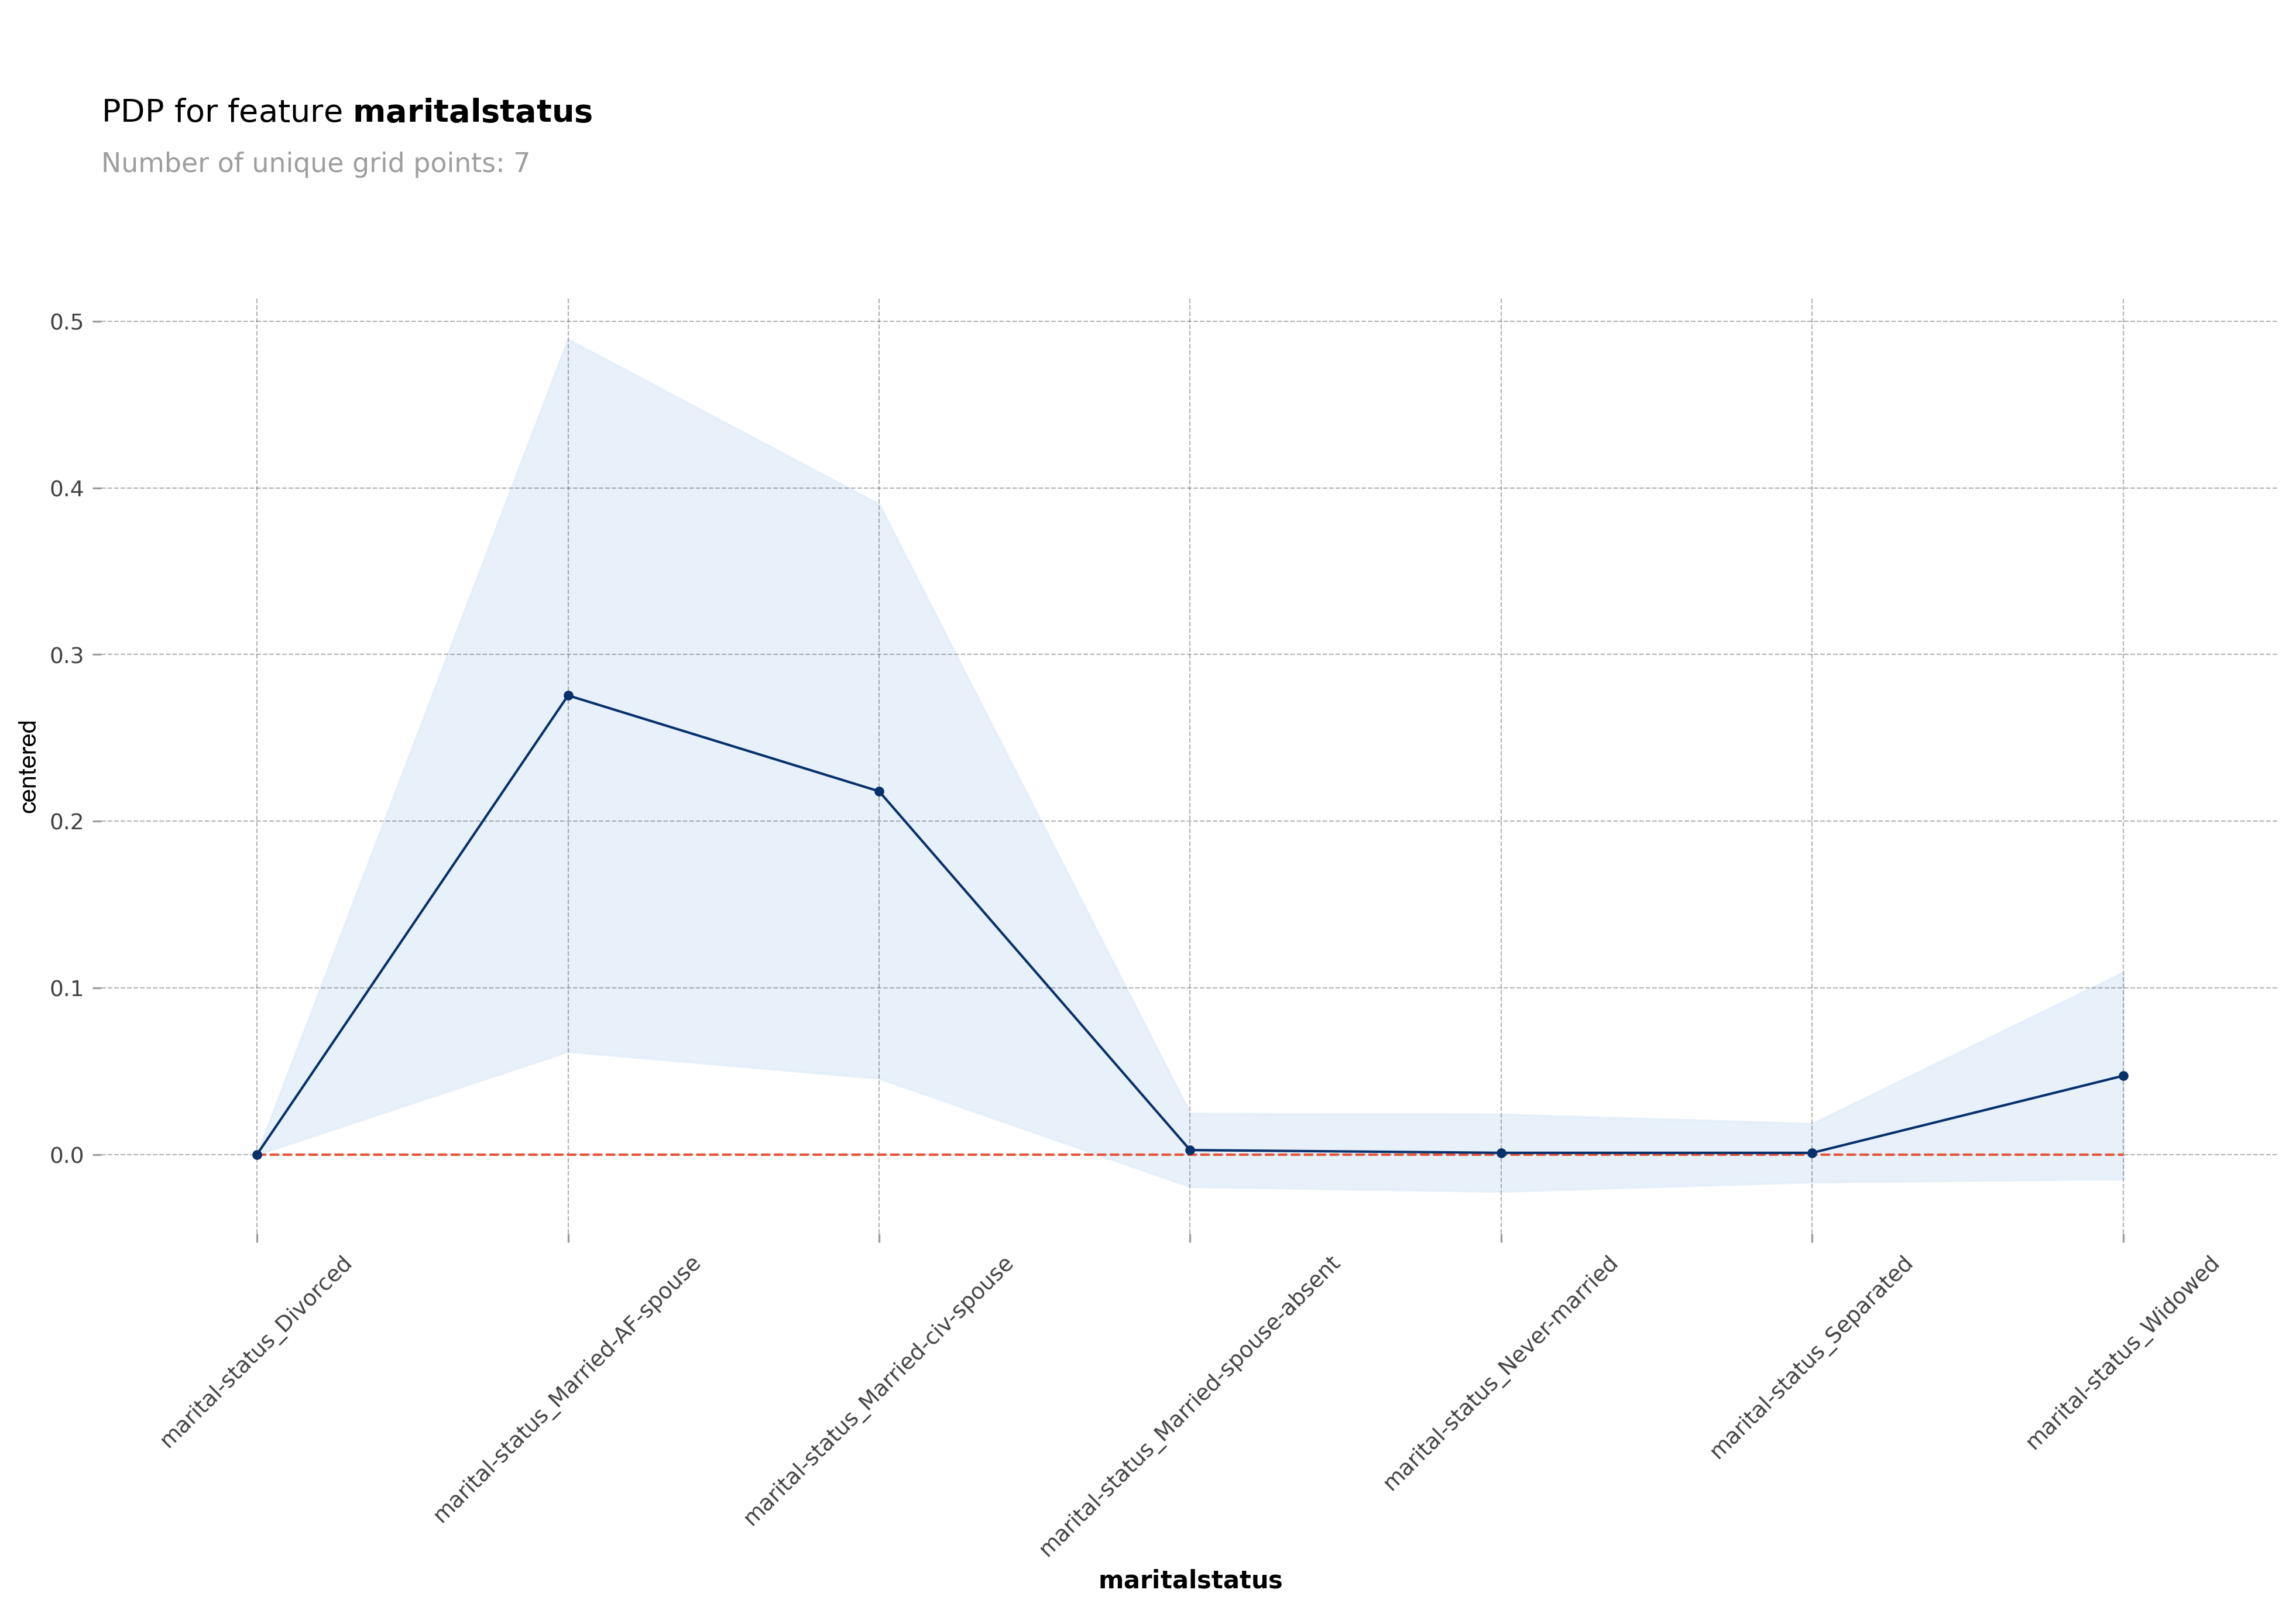

In [69]:
# categorical feature
X_full_copy = X_full.copy()

pdp_married = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=marrige_columns,
    feature_name="marital status",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_married.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

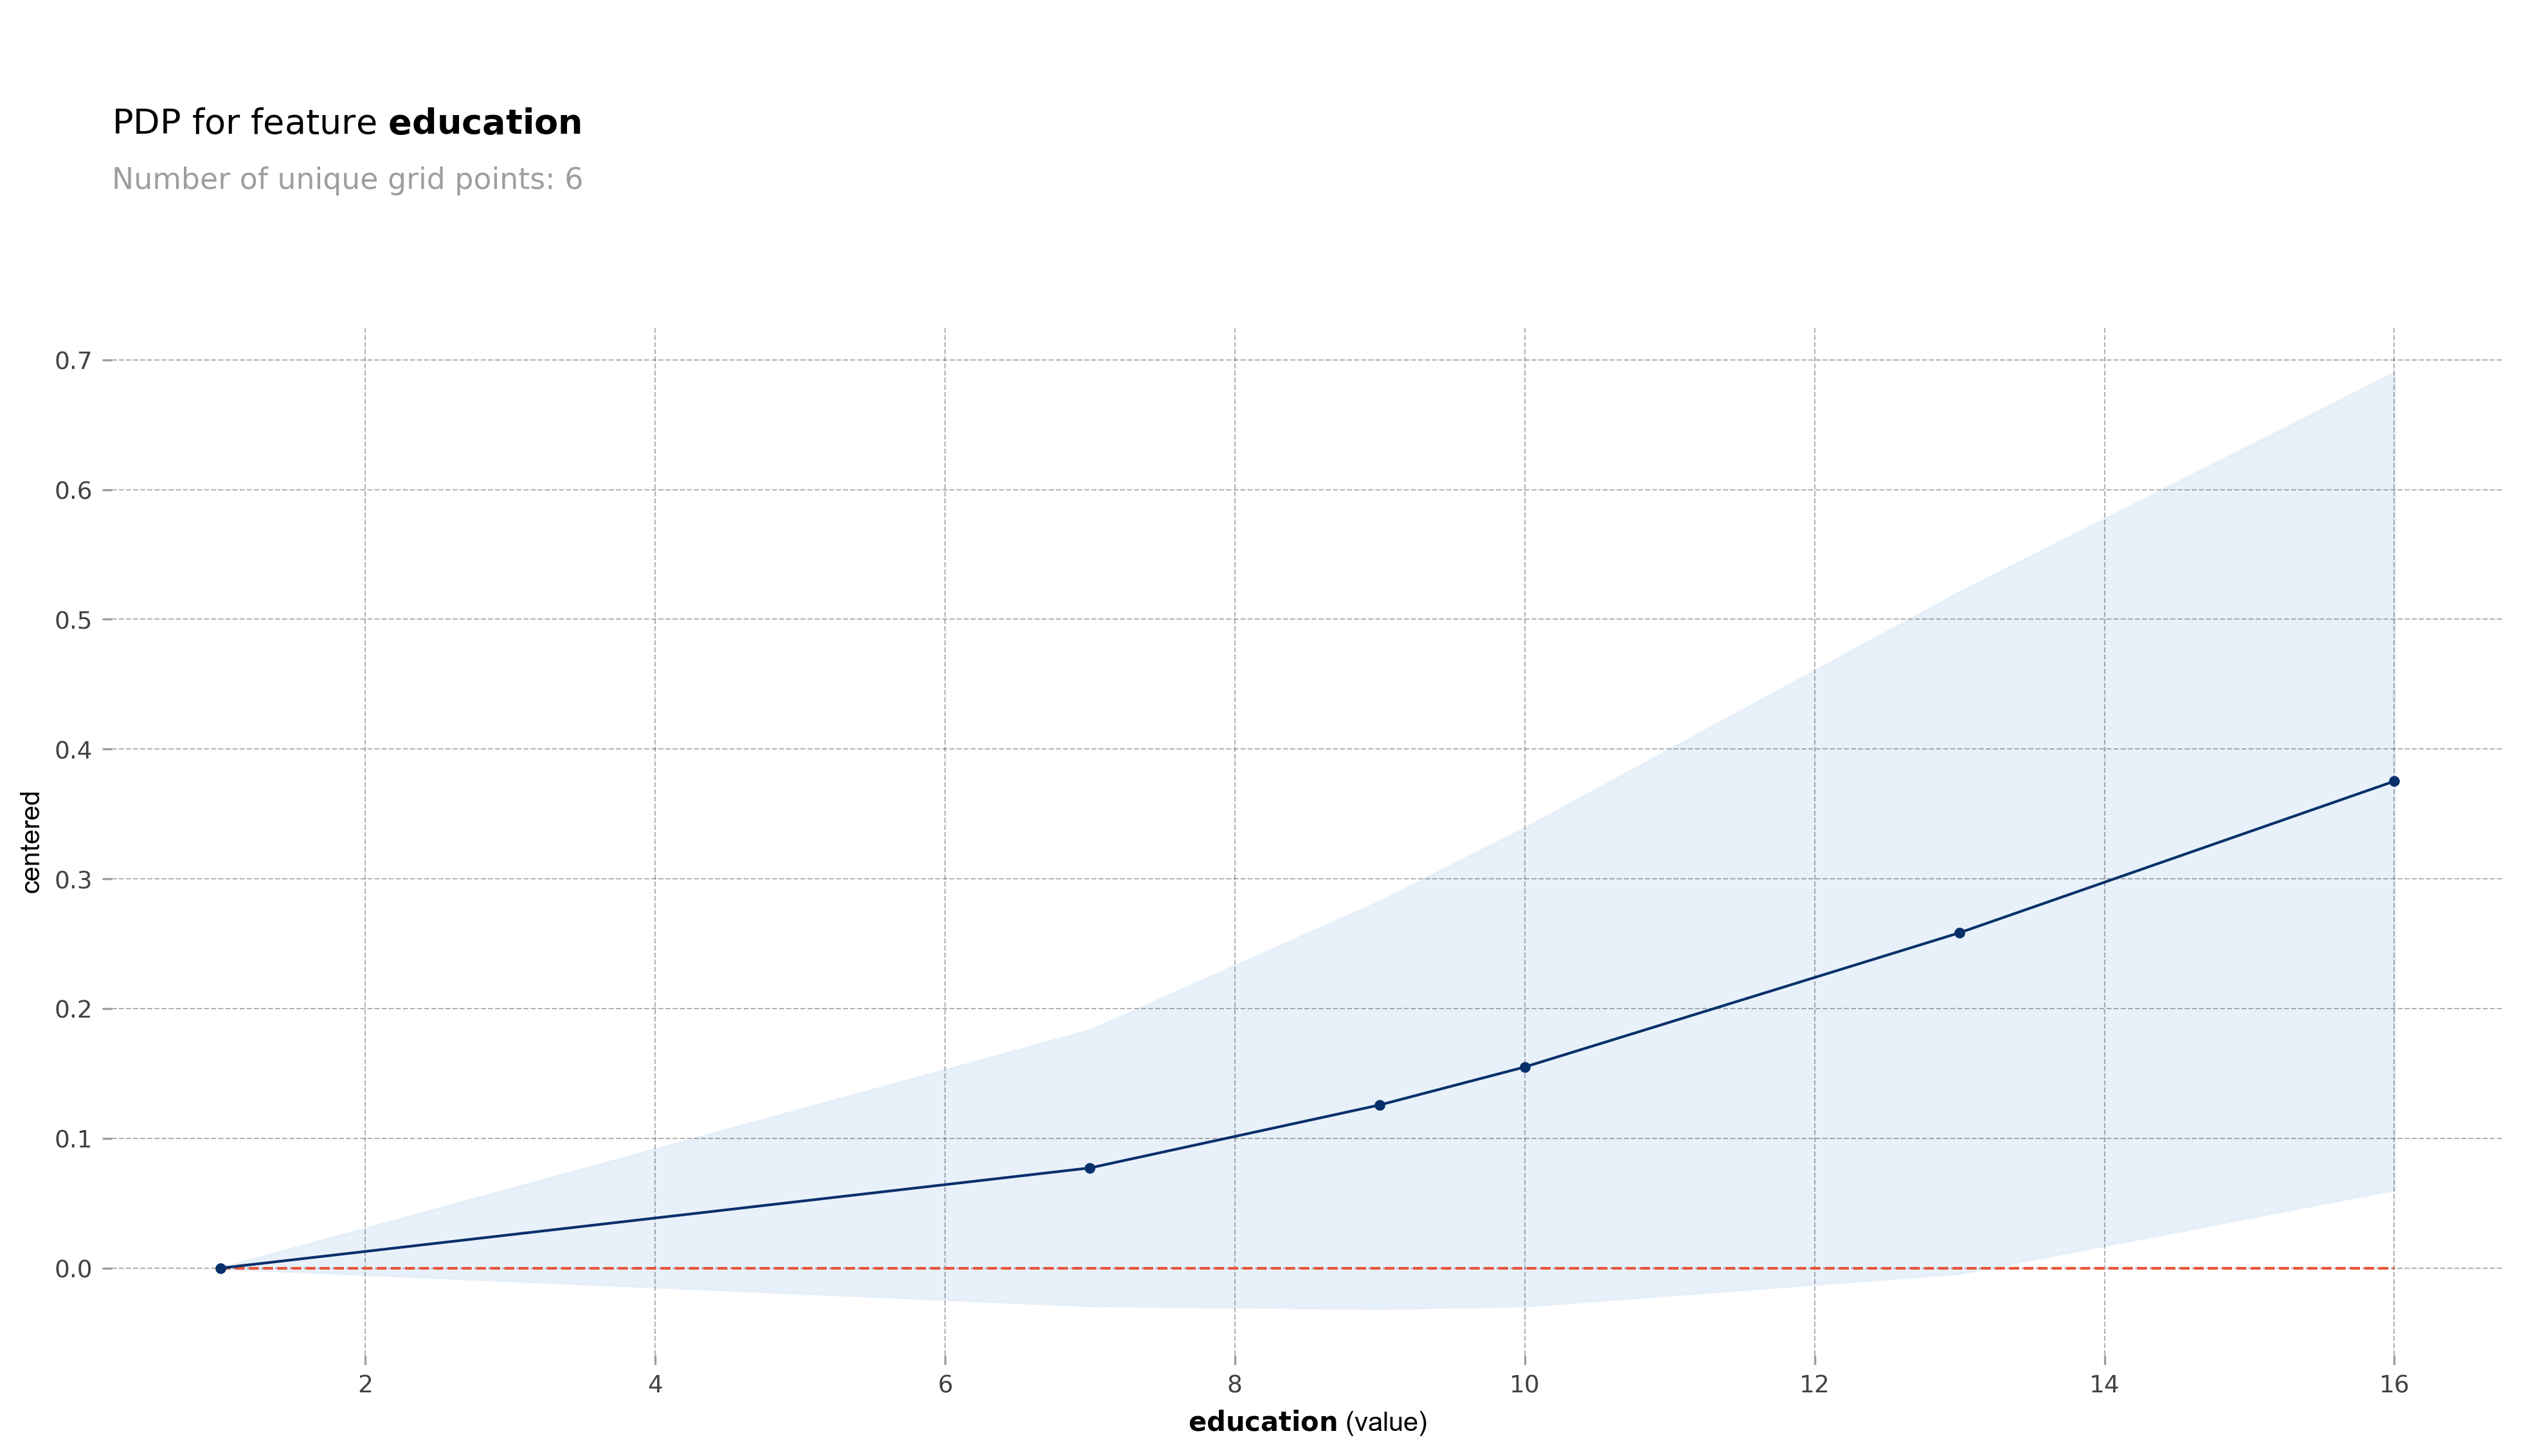

In [72]:
# education level
X_full_copy = X_full.copy()

pdp_education = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="education-num",
    feature_name="education",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_education.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/7 [00:00<?, ?it/s]

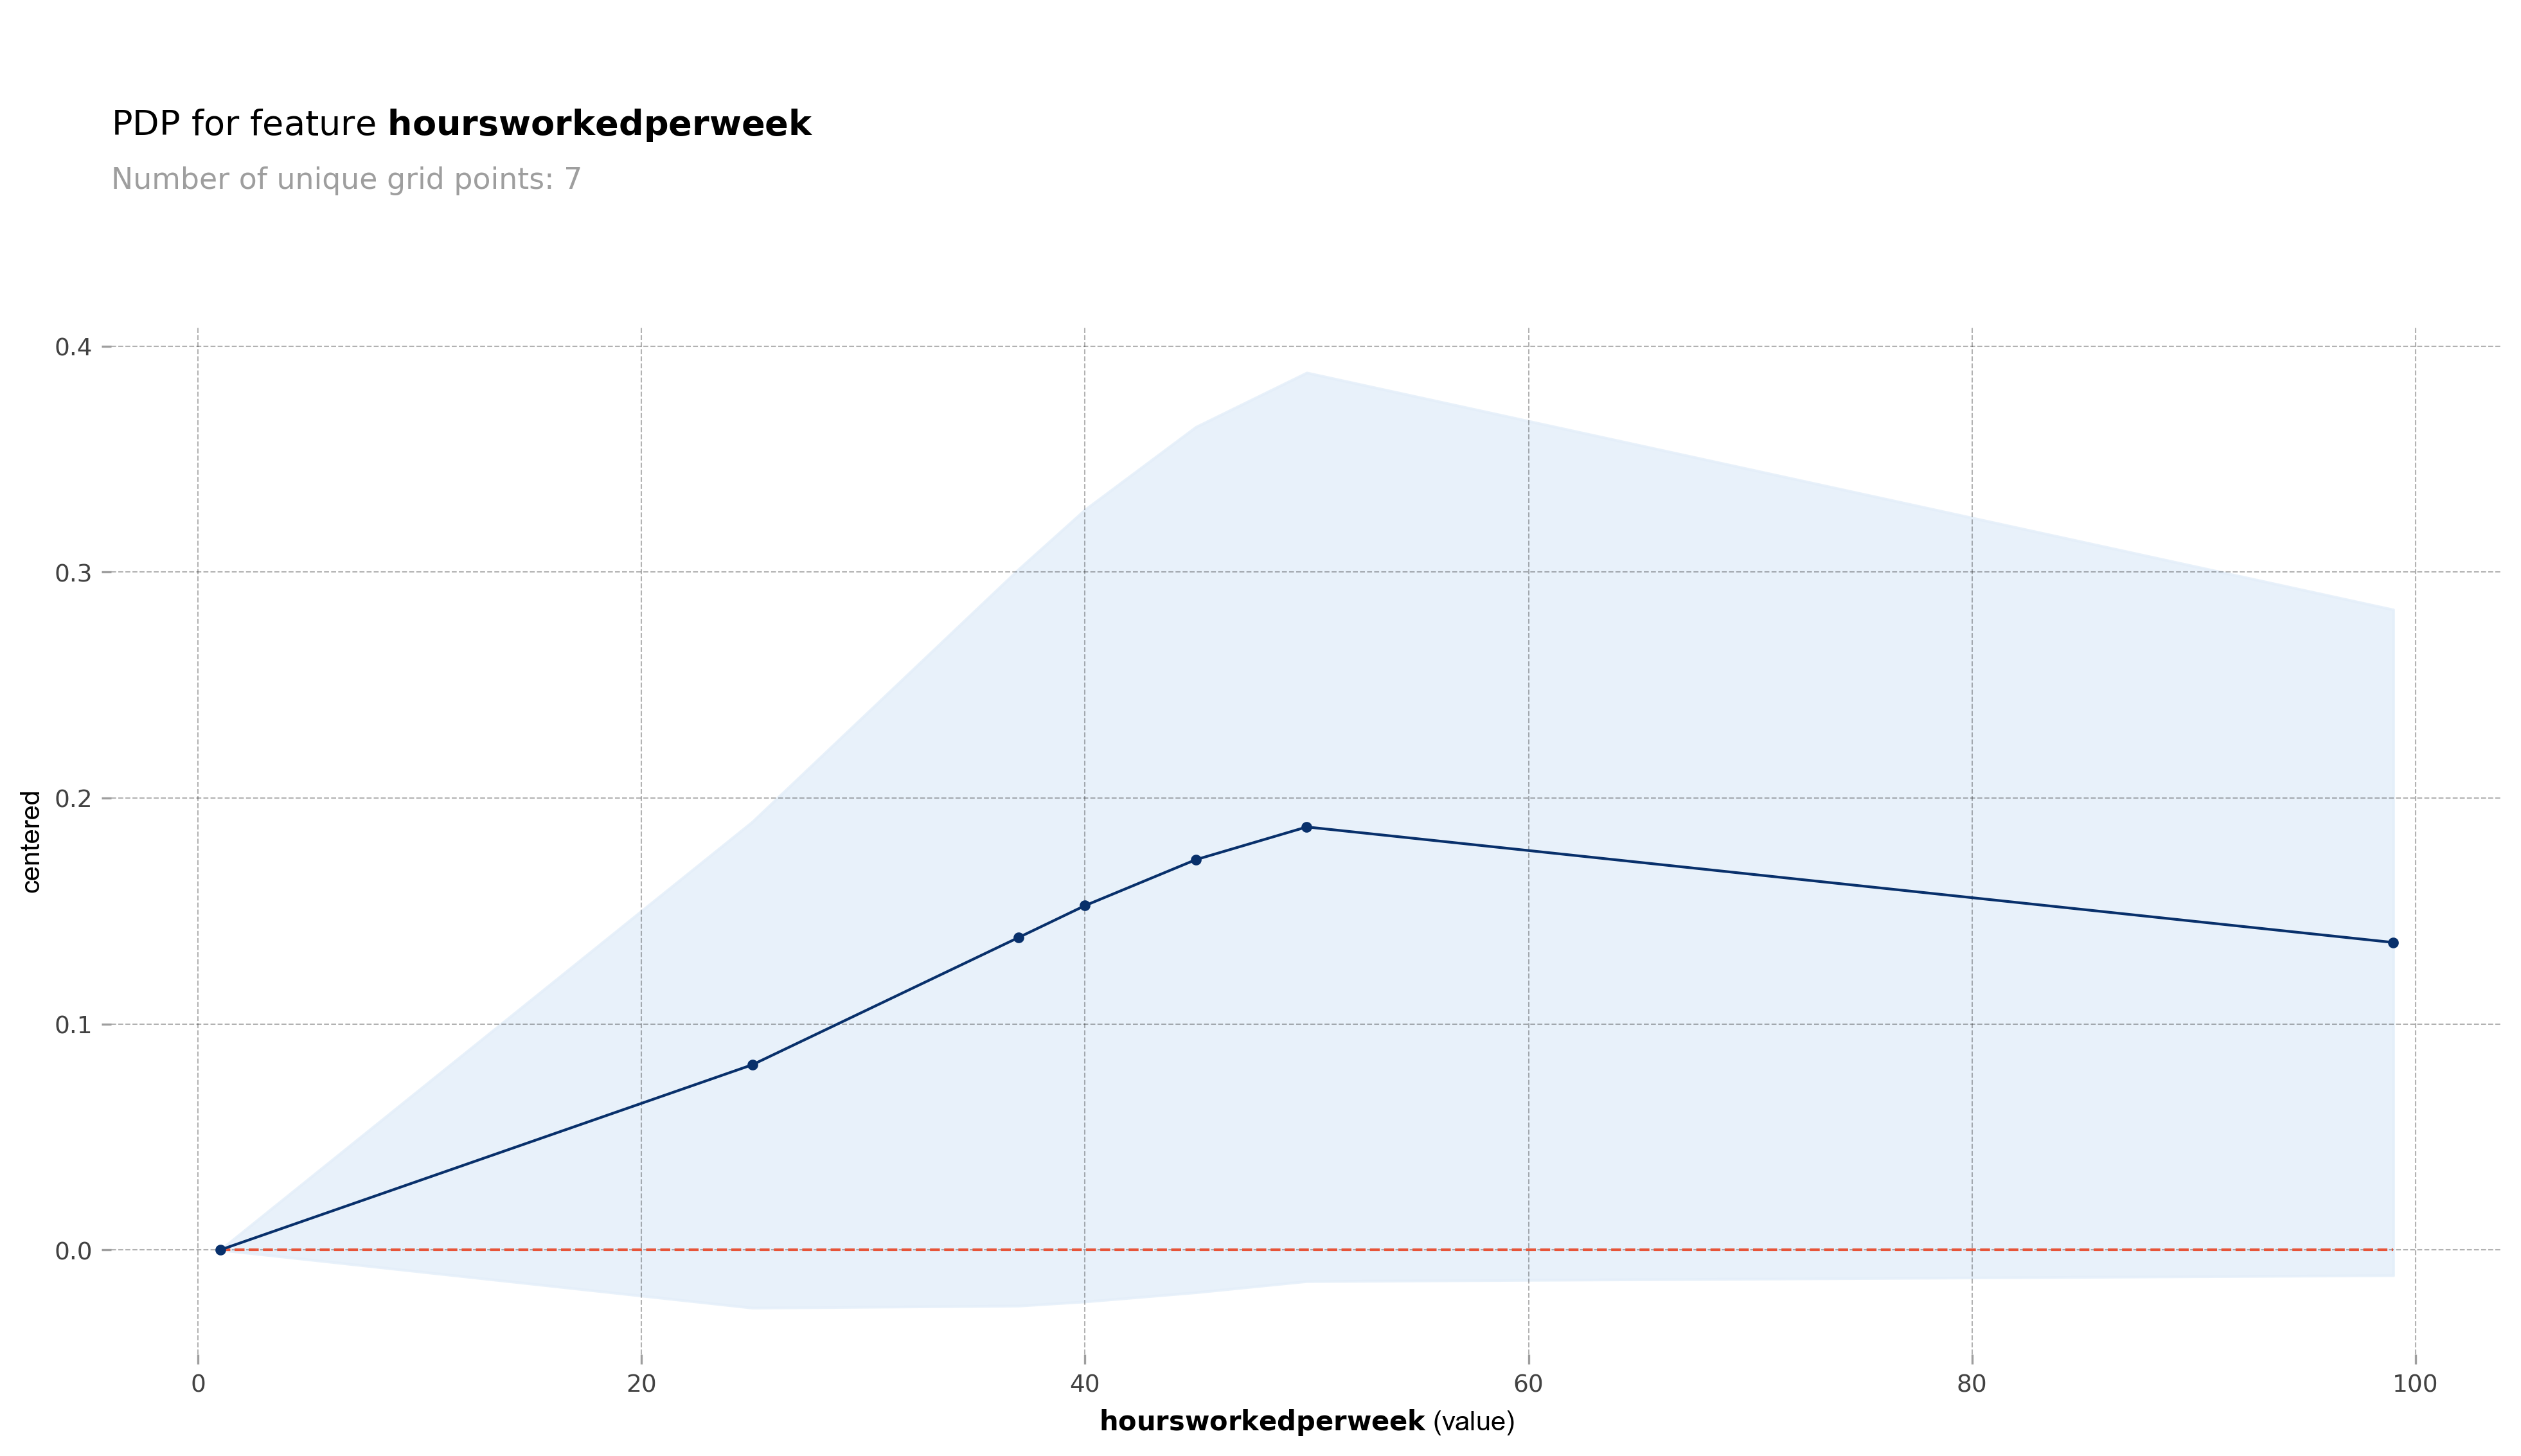

In [73]:
# hours-per-week
X_full_copy = X_full.copy()

pdp_hours = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="hours-per-week",
    feature_name="hoursworkedperweek",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_hours.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

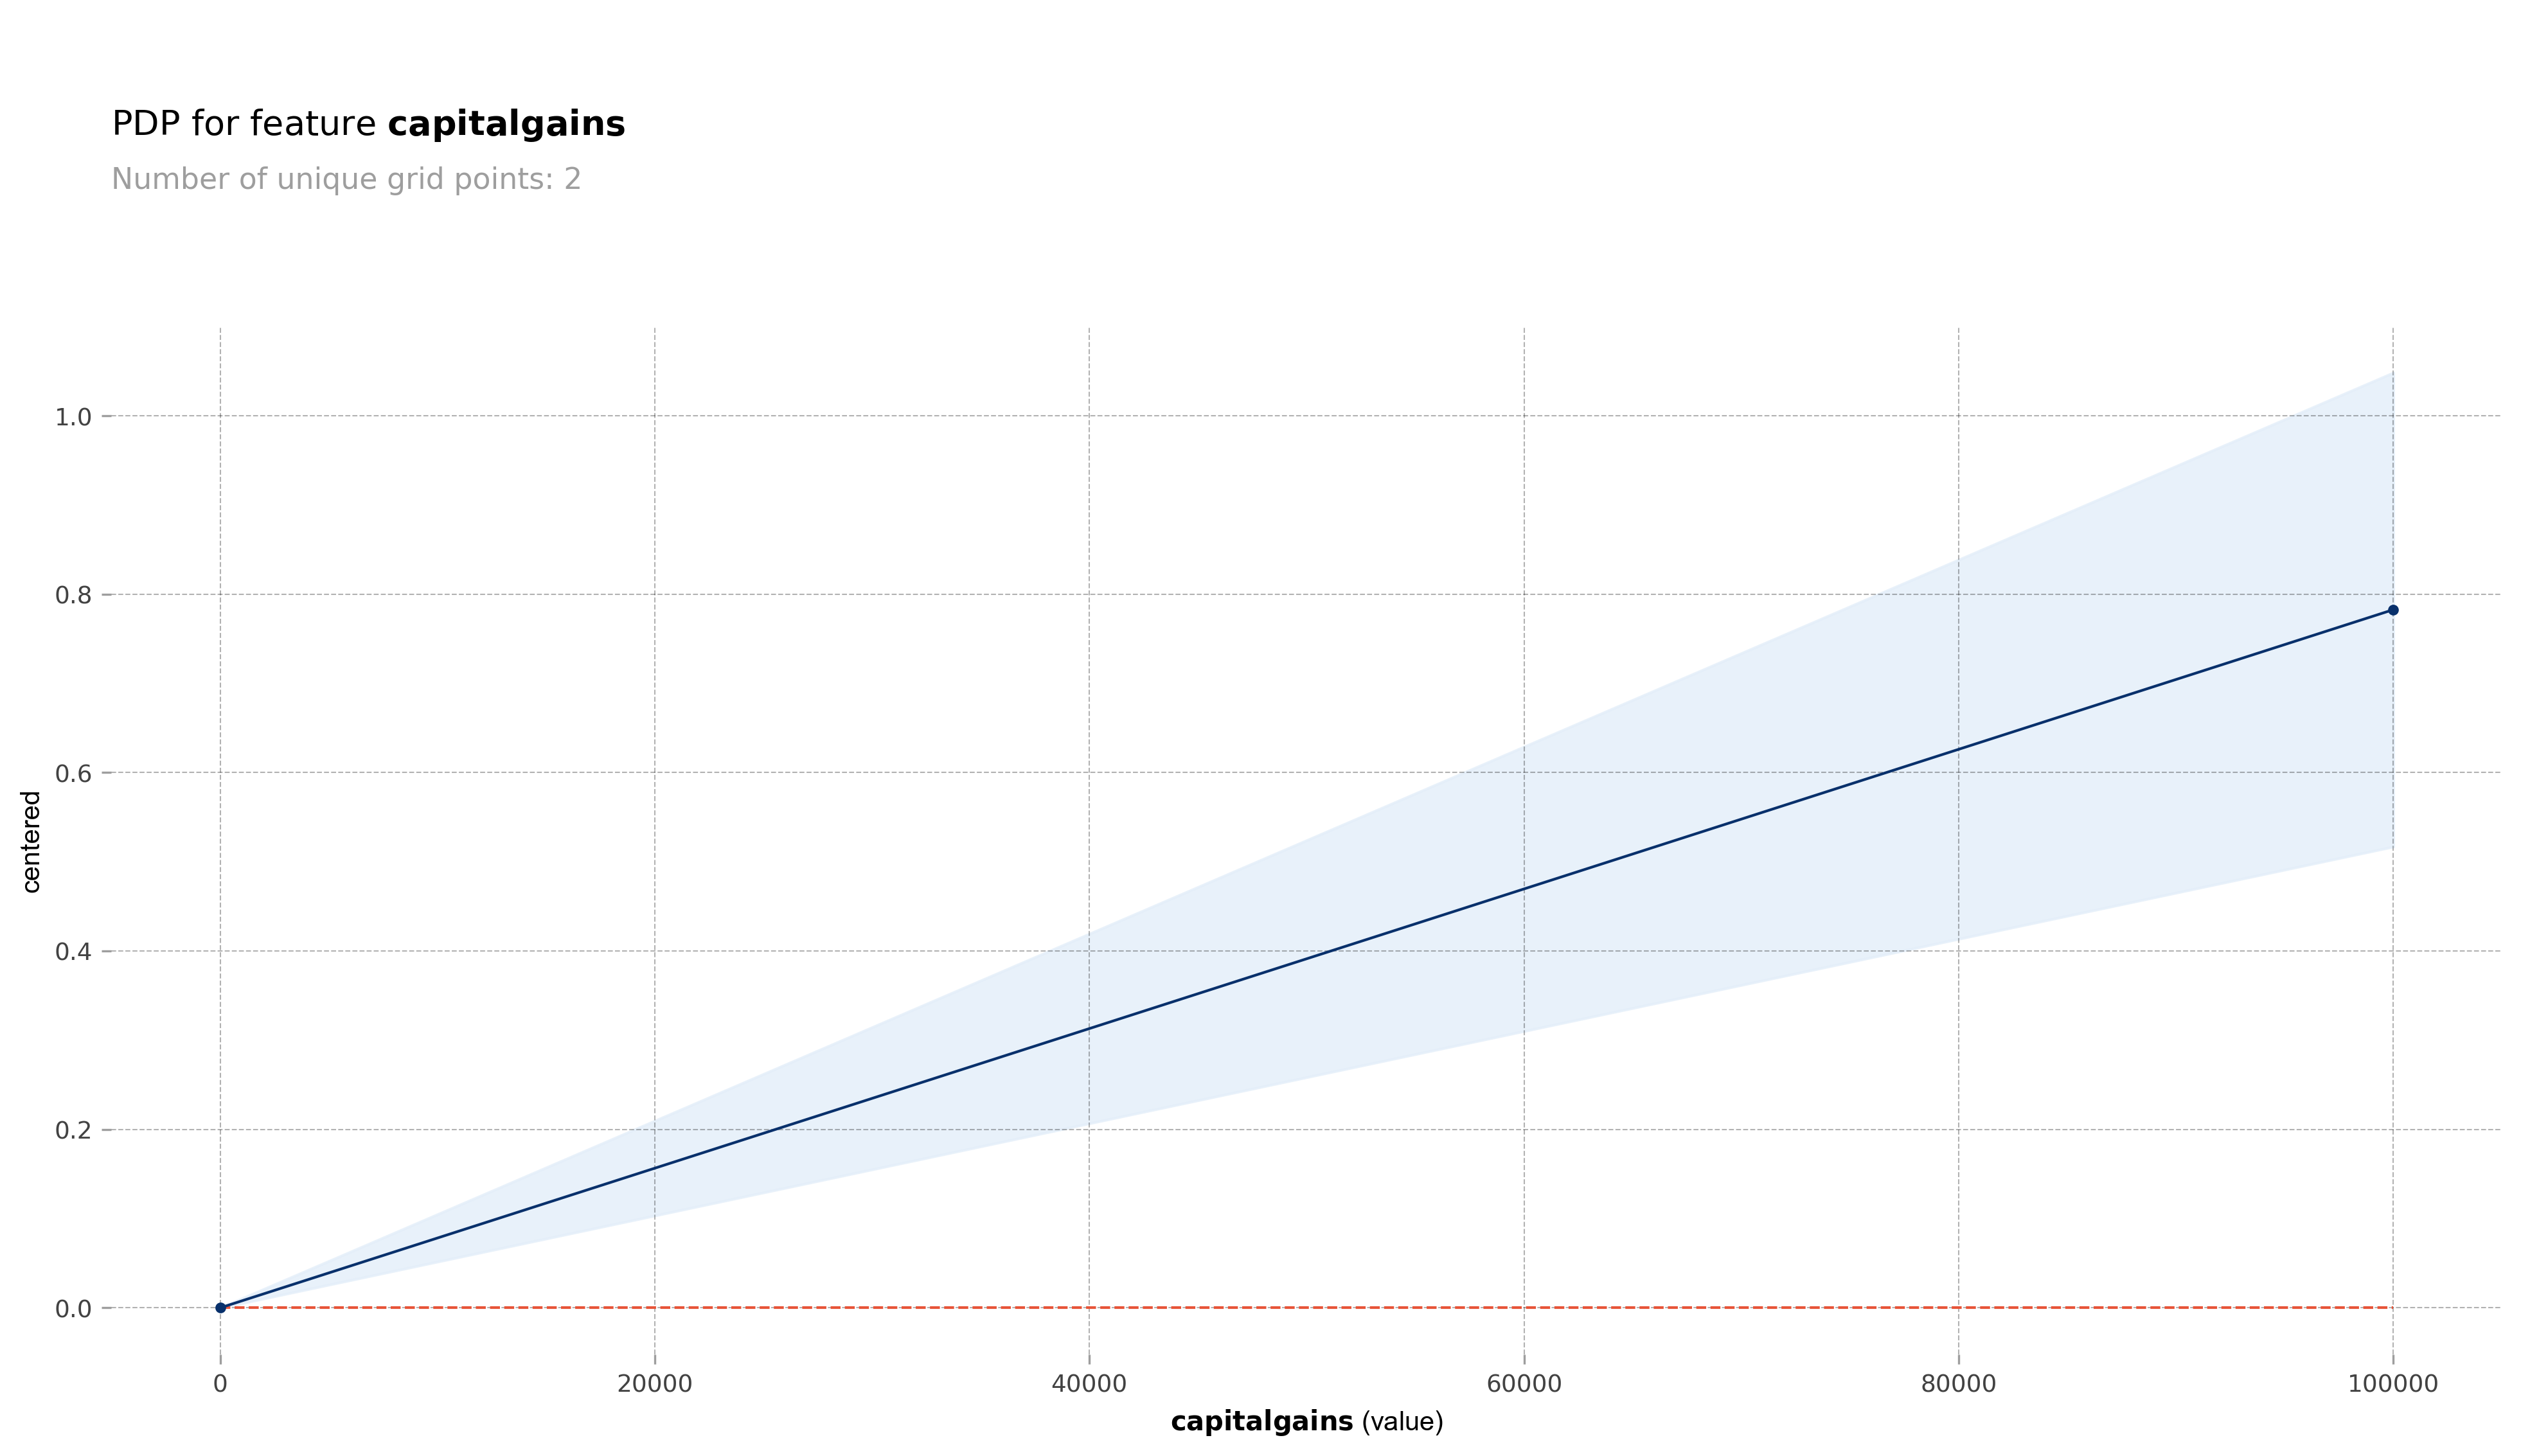

In [78]:
# captial gains
X_full_copy = X_full.copy()

pdp_cp = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature="capital-gain",
    feature_name="capital gains",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_cp.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
# Show the plot
plt.show()

obtain pred_func from the provided model.


  0%|          | 0/16 [00:00<?, ?it/s]

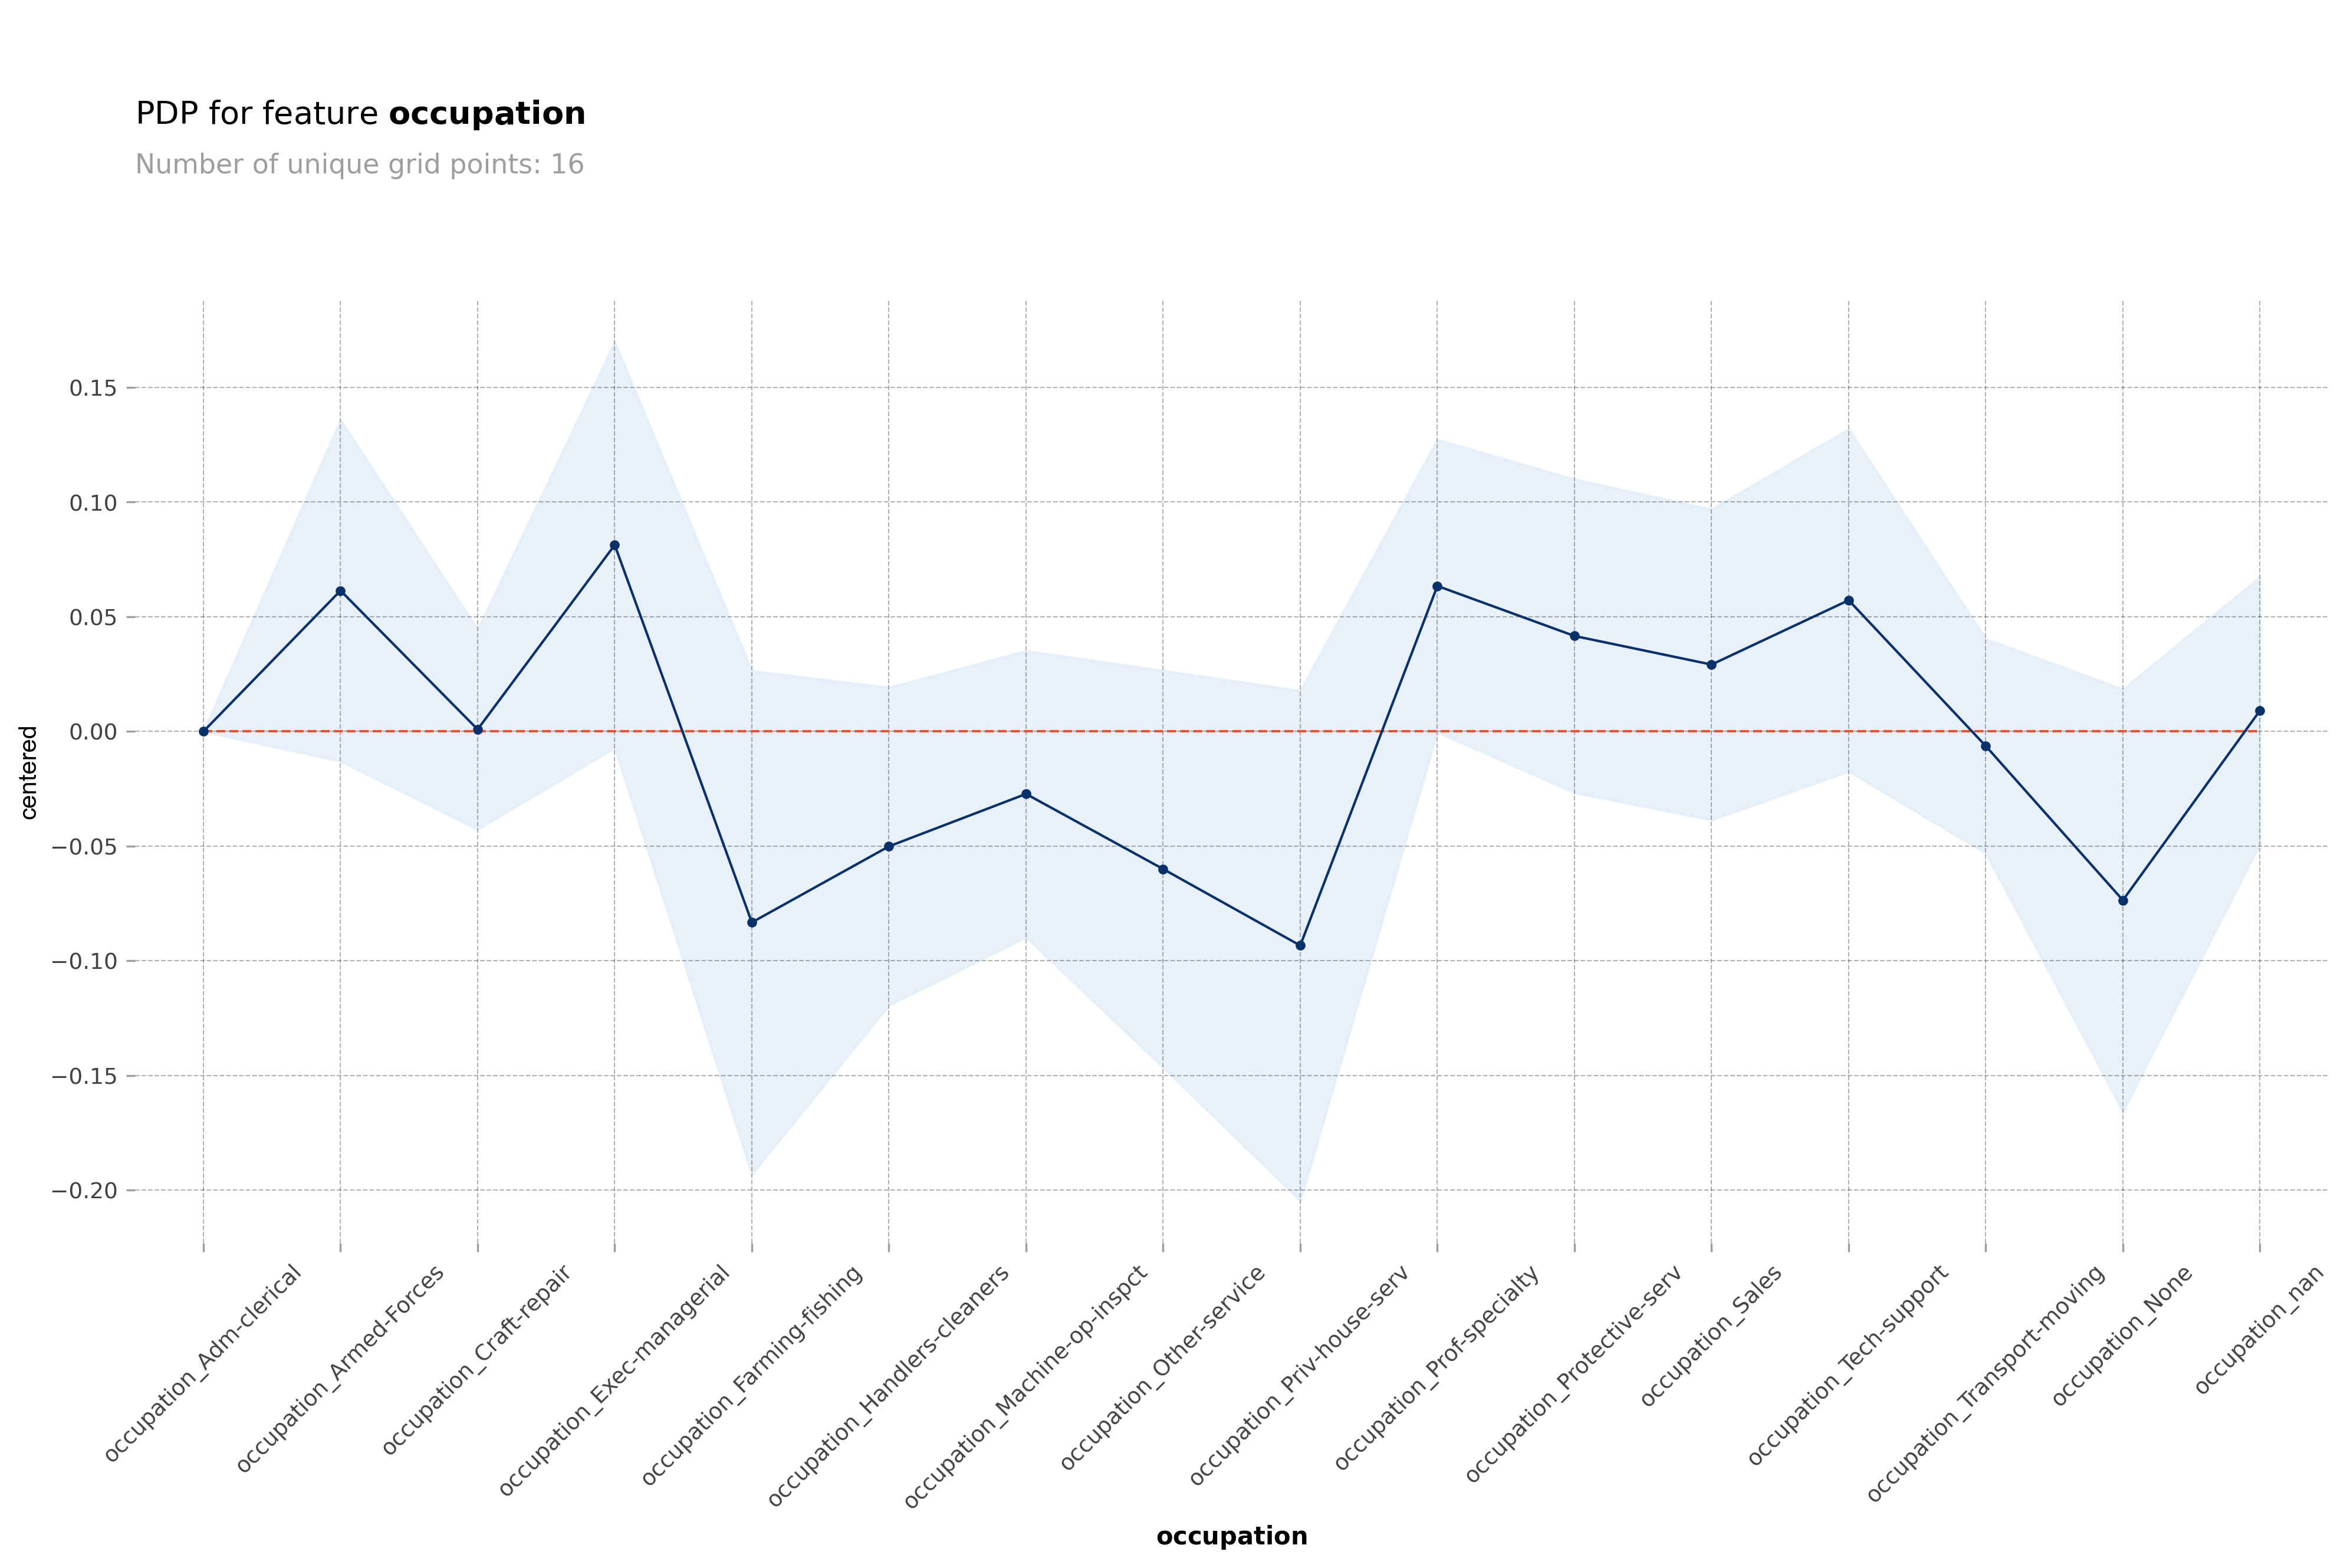

In [79]:
# occupation categorical
occup_columns = [col for col in X_full.columns if col.startswith("occupation_")]


# categorical feature
X_full_copy = X_full.copy()

pdp_occup = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=occup_columns,
    feature_name="occupation",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_occup.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

plt.show()

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

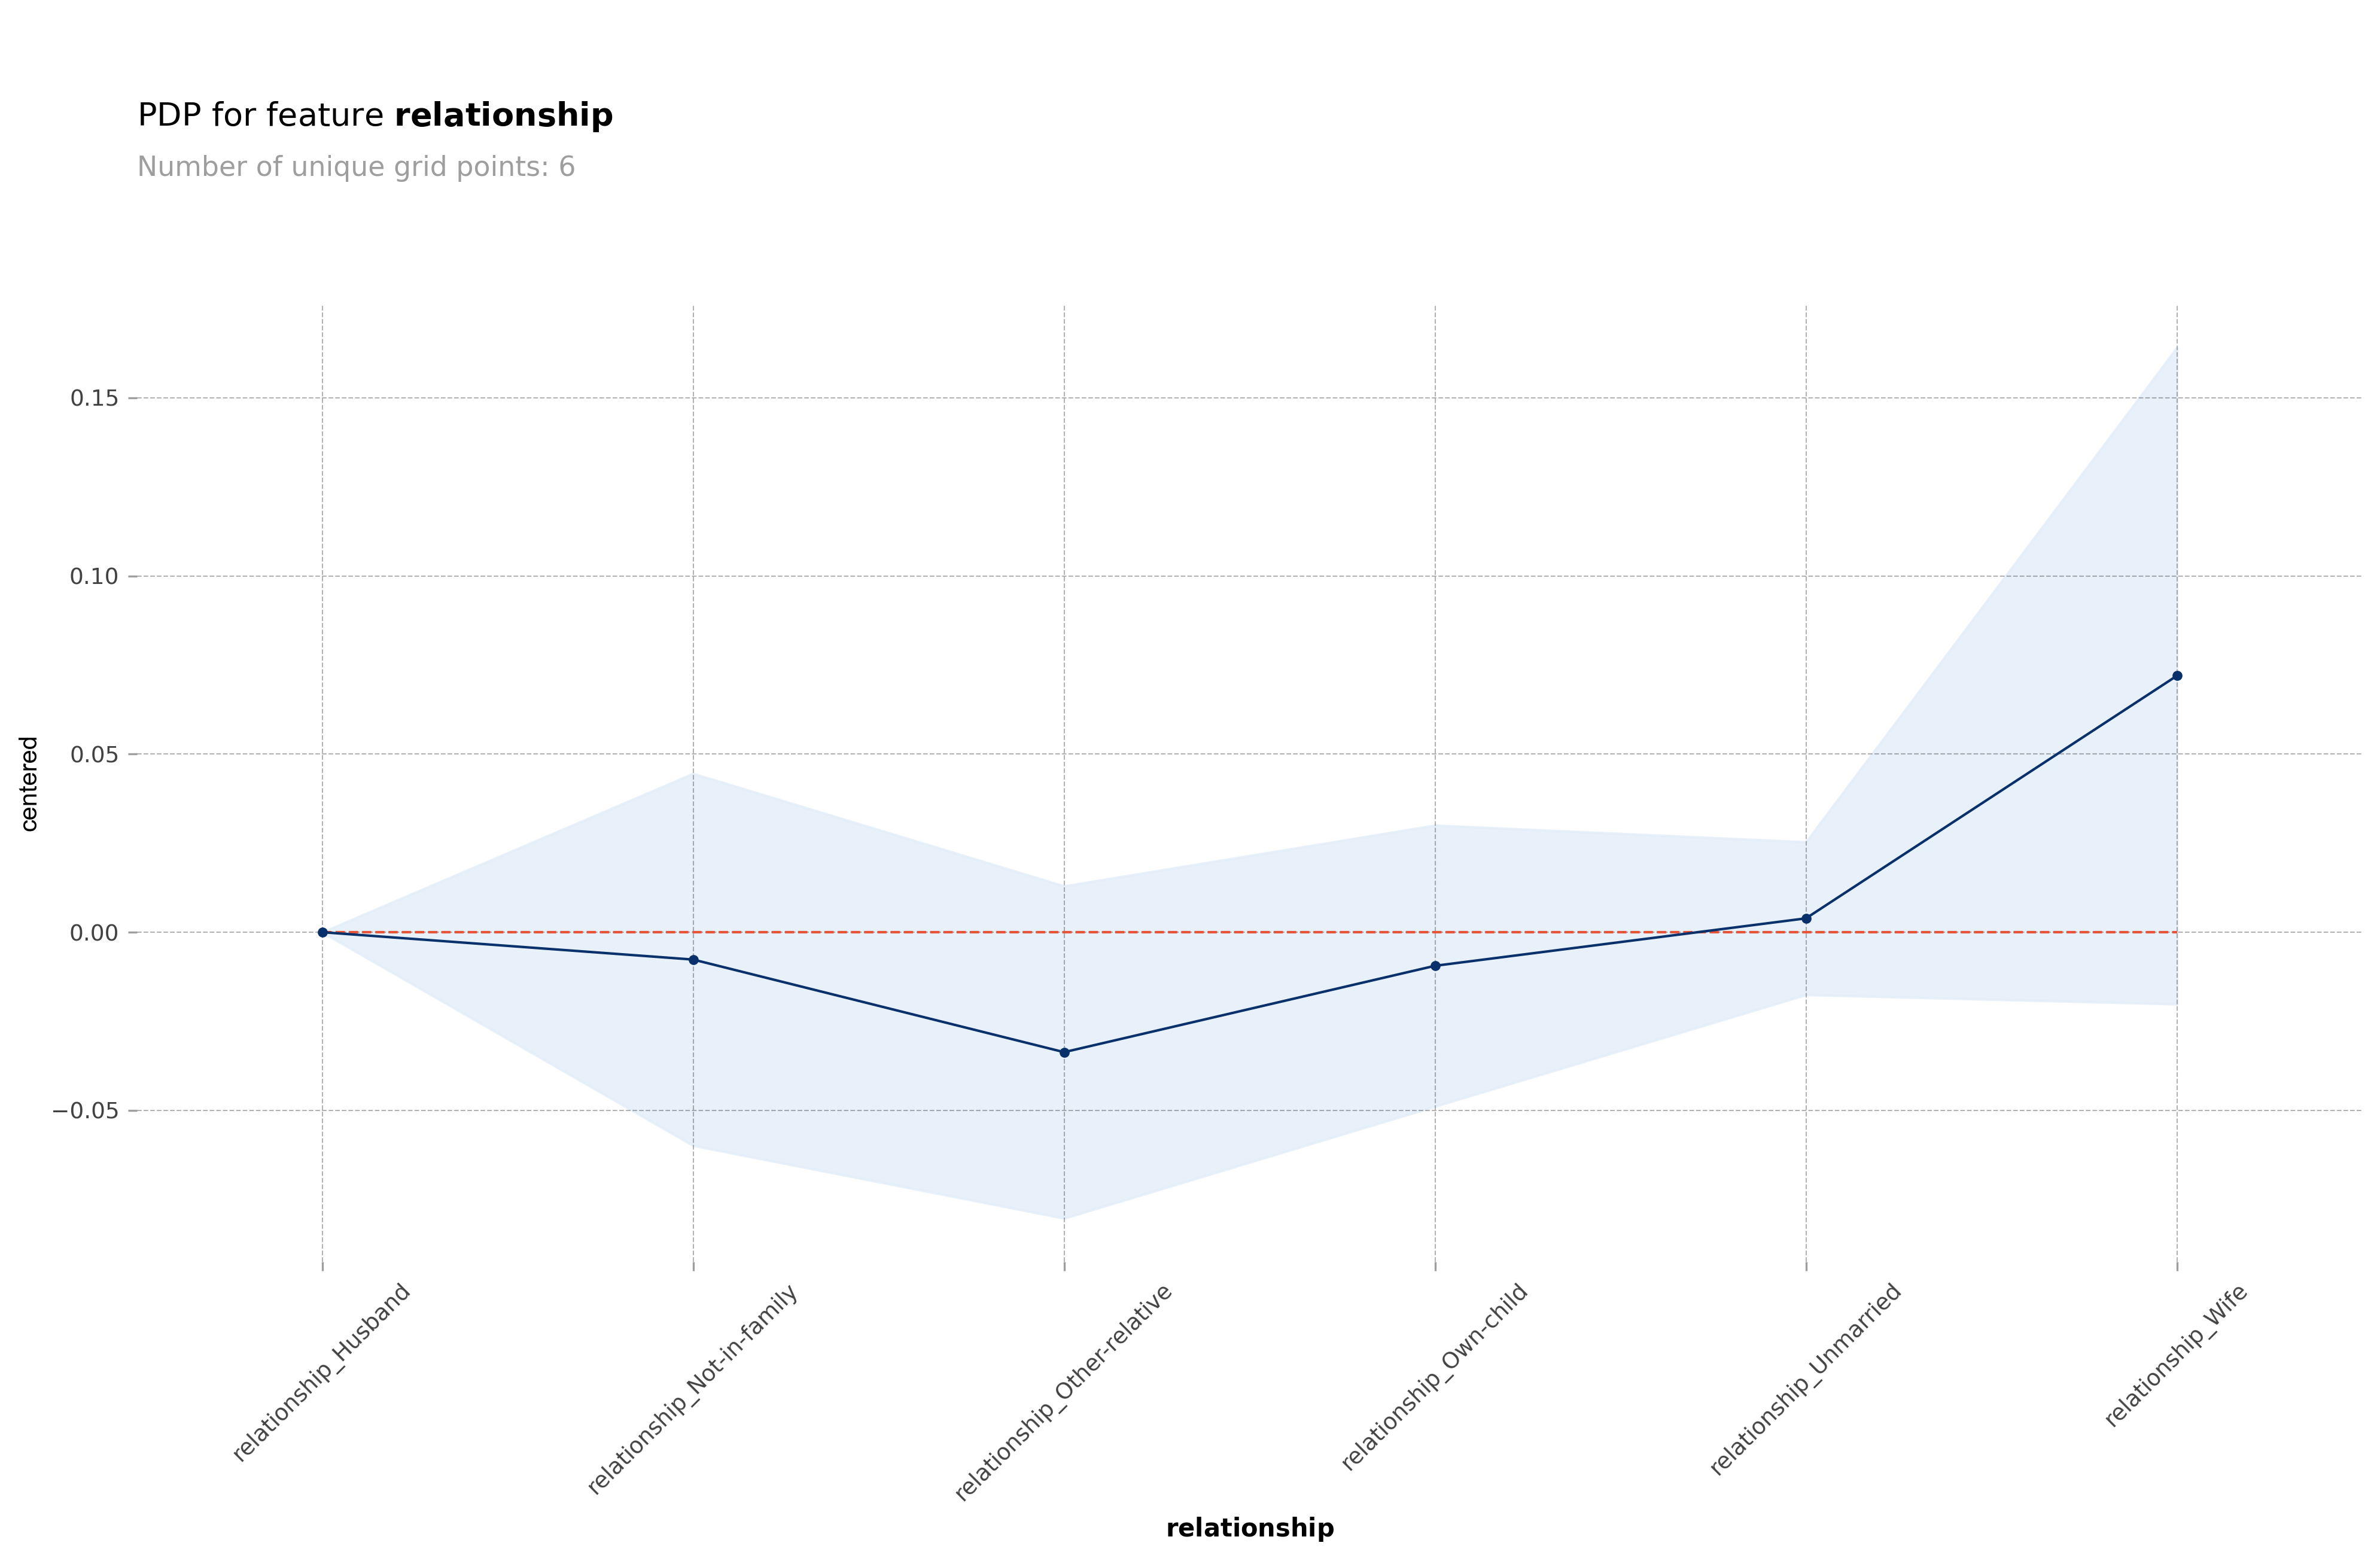

In [80]:
# relationship categorical
rel_columns = [col for col in X_full.columns if col.startswith("relationship_")]


# categorical feature
X_full_copy = X_full.copy()

pdp_rel = pdp.PDPIsolate(
    model=mlp_final,
    df=X_full_copy,
    model_features=X_full_copy.columns,
    feature=rel_columns,
    feature_name="relationship",
    data_transformer=data_trans,
    n_classes=2,
)

fig, axes = pdp_rel.plot(
    center=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method="accurate",
    to_bins=False,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="matplotlib",
    template="plotly_white",
)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# education category not neded
# fnl_weight not needed those columns are useless

### Local-agonistic methods 

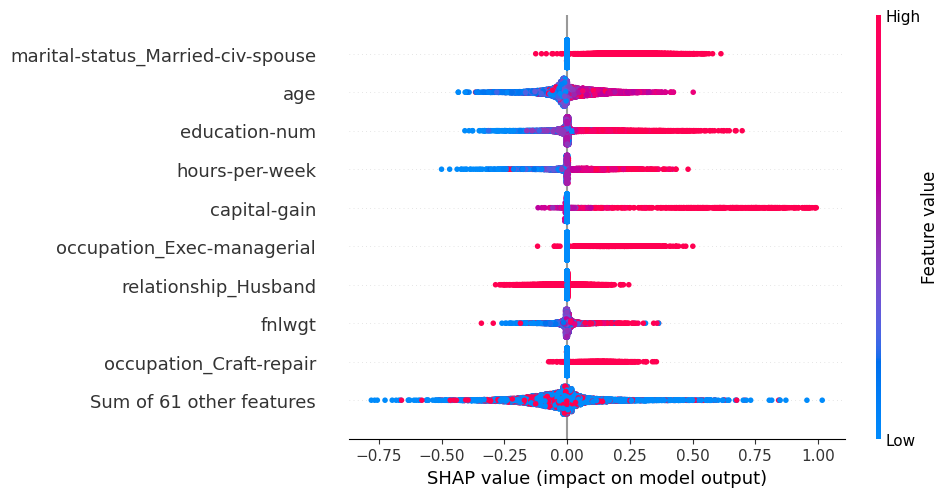

In [104]:
# SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values)

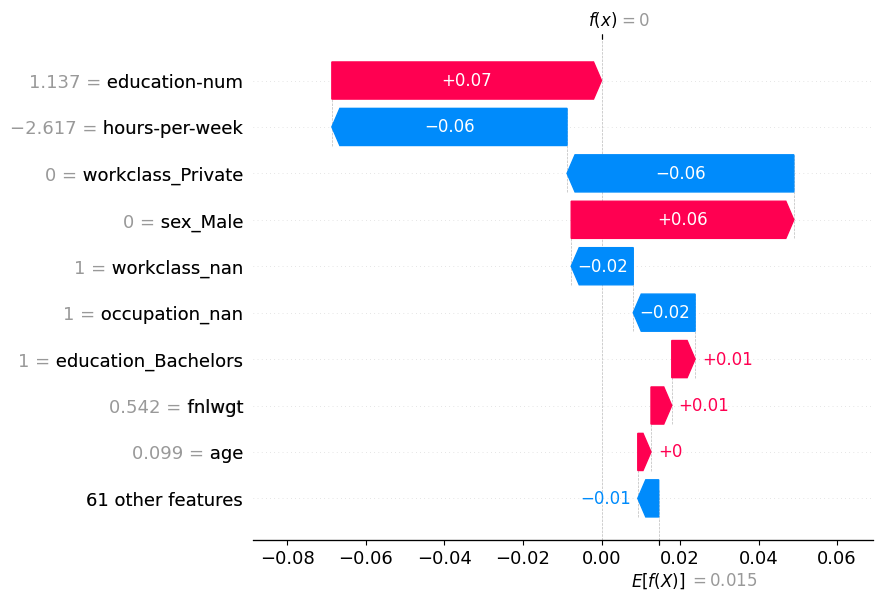

In [107]:
# SHAP Waterfall Plot (indvidual prediction)
shap.plots.waterfall(shap_values[12])

In [109]:
y_pred_proba = mlp_final.predict_proba(X_test_ss)[:, 1]
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
# fix
results.to_csv("../40_results/mlp_prob.csv")